# Get MMGBSA Energy Terms and Energy Corrections

The energy terms are obtained from gmx_MMGBSA https://valdes-tresanco-ms.github.io/gmx_MMPBSA/dev/
The energy corrections are obtained from custom scripts based on VSGB 2.0 https://doi.org/10.1002/prot.23106 

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import tempfile
import shutil

import MDAnalysis
from MDAnalysis.analysis.hydrogenbonds import HydrogenBondAnalysis as HBA
from MDAnalysis.coordinates.memory import MemoryReader
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr, kruskal

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_dir = "../MD_simulations" #directory containing all trajectories
conversion = 1.7 # Conversion unit (default conversion=1 is kcal/mol. conversion=1.7 converts to kT)

# Load VDW radii mapping from CSV once and create a dictionary
vdw_mapping = pd.read_csv("vdw_mapping.csv")
vdw_dict = dict(zip(vdw_mapping['Atom Name'], vdw_mapping['VDW Radius']))

## Functions to get energy corrections

All corrections except for entropy were based on "The VSGB 2.0 model: A next generation energy model for high resolution protein structure modeling"  https://doi.org/10.1002/prot.23106 

The entropy energy was obtained using the empirical formula found in https://doi.org/10.1093/bioinformatics/btx698

In [3]:
# Get universe from MDAnalysis 
def get_universe(psf, traj):
    '''
    Initializes and returns a Universe object from MDAnalysis. Make sure water is stripped or it will
    take too long to run any analysis.

    Parameters:
    psf (str): Path to the Protein Structure File containing topology information (.psf, .tpr, .prmtop).
    traj (str): Path to the trajectory file containing atomic coordinates (.xtc, .trr, .dcd).

    Returns:
    MDAnalysis.core.universe.Universe: A new MDAnalysis Universe object.
    '''
    # Load the original universe
    u = MDAnalysis.Universe(psf, traj)
    
    return u

### Hydrogen Bonds

In [4]:
##############################################
# 1) Convert HB Analysis Output into a DataFrame
##############################################
def make_hb_df(hbonds, u):
    """
    Converts hydrogen bond analysis results into a pandas DataFrame.
    
    Parameters:
      hbonds : HydrogenBondAnalysis object (contains HB data).
      u      : MDAnalysis Universe (provides atom/residue info).
      
    Returns:
      df     : DataFrame with columns for Frame, donor/acceptor indices, distances, angles,
               and donor/acceptor residue and atom names.
    """
    df = pd.DataFrame(hbonds.results.hbonds[:, :4].astype(int),
                      columns=["Frame", "Donor_ix", "Hydrogen_ix", "Acceptor_ix"])
    df["Distances"] = hbonds.results.hbonds[:, 4]
    df["Angles"] = hbonds.results.hbonds[:, 5]
    
    # Look up residue and atom names using the indices
    df["Donor resname"] = u.atoms[df.Donor_ix].resnames
    df["Acceptor resname"] = u.atoms[df.Acceptor_ix].resnames
    df["Donor resid"] = u.atoms[df.Donor_ix].resids
    df["Acceptor resid"] = u.atoms[df.Acceptor_ix].resids
    df["Donor name"] = u.atoms[df.Donor_ix].names
    df["Acceptor name"] = u.atoms[df.Acceptor_ix].names
    return df

##############################################
# 2) Extract Hydrogen Bonds Between Protein and DNA
##############################################
def get_hb(u):
    """
    Identifies hydrogen bonds between proteins and nucleic acids in the Universe.
    
    Parameters:
      u : MDAnalysis Universe.
      
    Returns:
      DataFrame with HB information.
    """
    hb = HBA(universe=u, between=['nucleic', 'protein'])
    hb.run()
    return make_hb_df(hb, u)

##############################################
# 3) Alpha Assignment for Protein Atoms (Backbone and Side Chain)
##############################################
def alpha_protein(res, atom, is_donor):
    """
    Returns the alpha coefficient for a protein atom.
    
    Backbone atoms:
      - Backbone N (donor): +0.5 (or +1.5 for N-terminal "N3")
      - Backbone O/OXT (acceptor): -0.5
      - C-terminal oxygens (O2, OC1, OC2): -1.5
      
    Side-chain rules:
      - Strong donors: e.g. LYS, ARG, HIP → +1.5 if the atom is an N.
      - Strong acceptors: e.g. ASP, GLU → -1.5 if the atom is an O.
      - Ambiguous polar residues (e.g. SER, THR, ASN, GLN, TYR, TRP, HIS/HIE/HID):
          Return a tuple (0.5, -0.5) indicating that the residue can act as either.
    
    Nonpolar side chains yield 0.
    
    Parameters:
      res     : Residue name.
      atom    : Atom name.
      is_donor: True if the role is as donor.
    
    Returns:
      Either a float (e.g., 1.5, 0.5, -0.5, -1.5) or a tuple (0.5, -0.5) if ambiguous.
    """
    # Backbone treatment (common names)
    bb_map = {
        "N": 0.5, "N3": 1.5,    # "N3" treated as N-terminal strong donor.
        "O": -0.5, "OXT": -0.5,
        "O2": -1.5, "OC1": -1.5, "OC2": -1.5  # C-terminal strong acceptors.
    }
    if atom in bb_map:
        return bb_map[atom]
    
    # Side-chain definitions:
    strong_donors = {"LYS": 1.5, "ARG": 1.5, "HIP": 1.5}  # HIP is fully protonated.
    strong_acceptors = {"ASP": -1.5, "GLU": -1.5}
    ambiguous = {"SER": (0.5, -0.5), "THR": (0.5, -0.5),
                 "ASN": (0.5, -0.5), "GLN": (0.5, -0.5),
                 "TYR": (0.5, -0.5), "TRP": (0.5, -0.5)}
    # Histidines
    if res in {"HIS", "HIE", "HID"}:
        return (0.5, -0.5)
    
    if res in strong_donors and is_donor and atom.startswith("N"):
        return strong_donors[res]
    if res in strong_acceptors and (not is_donor) and atom.startswith("O"):
        return strong_acceptors[res]
    if res in ambiguous:
        return ambiguous[res][0] if is_donor else ambiguous[res][1]
    return 0.0

##############################################
# 4) Alpha Assignment for DNA Atoms
##############################################
def alpha_dna(res, atom, is_donor):
    """
    Returns the alpha coefficient for a DNA atom.
    
    - Phosphate oxygens (OP1, OP2, O1P, O2P) are strong acceptors (-1.5).
    - Base atoms: Exocyclic amines and ring N with H are weak donors (+0.5).
      Base carbonyl oxygens and nonprotonated ring N are weak acceptors (-0.5).
    - Sugar oxygens are treated as weak acceptors (-0.5).
    
    Parameters:
      res     : DNA residue name.
      atom    : Atom name.
      is_donor: True if evaluating donor role.
    
    Returns:
      Alpha coefficient (float).
    """
    if not is_donor and atom.upper() in {"OP1", "OP2", "O1P", "O2P"}:
        return -1.5
    if is_donor:
        return 0.5 if atom.upper() in {"N6", "N4", "N2", "N1", "N3"} else 0.0
    return -0.5 if atom.upper().startswith(("O", "N")) else 0.0

##############################################
# 5) Partner-Dependent Resolution of Ambiguity
##############################################
def get_aij(row):
    """
    Computes the effective donor (alpha_d) and acceptor (alpha_a) coefficients for a hydrogen bond,
    taking into account partner dependency for ambiguous (polar) residues.
    
    The logic is as follows:
      - If one partner (say, atom i) is ambiguous (has a tuple value) and the other is clear,
        then:
          * If the clear partner is a strong donor, force the ambiguous partner to act as a weak acceptor (–0.5).
          * If the clear partner is a strong acceptor, force the ambiguous partner to act as a weak donor (+0.5).
      - If both are ambiguous, count the bond twice (multiply the final interaction by 2)
        using the default weak values (0.5 for donor, –0.5 for acceptor).
    
    Parameters:
      row : A row from the HB DataFrame containing 'Donor resname', 'Donor name', 
            'Acceptor resname', 'Acceptor name'.
    
    Returns:
      Tuple (factor, alpha_d, alpha_a)
    """
    dna_res = {'DA','DT','DG','DC','A','T','G','C','U'}
    
    # Determine donor alpha value
    if row["Donor resname"] in dna_res:
        alpha_d = alpha_dna(row["Donor resname"], row["Donor name"], True)
        amb_d = False
    else:
        ad = alpha_protein(row["Donor resname"], row["Donor name"], True)
        if isinstance(ad, tuple):
            amb_d = True
            alpha_d = None
        else:
            amb_d = False
            alpha_d = ad
            
    # Determine acceptor alpha value
    if row["Acceptor resname"] in dna_res:
        alpha_a = alpha_dna(row["Acceptor resname"], row["Acceptor name"], False)
        amb_a = False
    else:
        aa = alpha_protein(row["Acceptor resname"], row["Acceptor name"], False)
        if isinstance(aa, tuple):
            amb_a = True
            alpha_a = None
        else:
            amb_a = False
            alpha_a = aa

    factor = 1.0
    # Resolve ambiguity if only one partner is ambiguous:
    if amb_d and not amb_a:
        if alpha_a < -1.0:   # clear partner is a strong acceptor → force ambiguous donor to be weak donor (+0.5)
            alpha_d = 0.5
        elif alpha_a > 1.0:  # clear partner is a strong donor → force ambiguous donor to be weak acceptor (–0.5)
            alpha_d = -0.5
        else:
            alpha_d = 0.5  # default for ambiguous donor
    if amb_a and not amb_d:
        if alpha_d > 1.0:    # clear donor is strong → force ambiguous acceptor to be weak acceptor (–0.5)
            alpha_a = -0.5
        elif alpha_d < -1.0: # clear donor is strong acceptor (unlikely) → force ambiguous acceptor to be weak donor (+0.5)
            alpha_a = 0.5
        else:
            alpha_a = -0.5  # default for ambiguous acceptor
    # If both are ambiguous, double count the contribution.
    if amb_d and amb_a:
        factor = 2.0
        alpha_d = 0.5
        alpha_a = -0.5
        
    return factor, alpha_d, alpha_a

##############################################
# 6) Hydrogen Bond Energy Correction Calculation
##############################################
def hb_energy(u):
    """
    Computes the hydrogen bonding energy correction for protein–DNA H-bonds.
    
    The energy is given by:
      E_HB = factor * (alpha_d * alpha_a) * exp[-(r_HA - r0)^2] * cos(theta_DHA - theta0)
    where:
      - r0 and theta0 are the optimal distance and angle.
      - 'factor' accounts for double counting if both partners are ambiguous.
    
    Parameters:
      u : MDAnalysis Universe.
      
    Returns:
      DataFrame with columns ['Frame', 'HB Energy'] containing the summed H-bond correction per frame.
    """
    df = get_hb(u)
    energies = []
    r0 = 1.94                    # optimal hydrogen-acceptor distance (Å)
    theta0 = np.radians(160)     # optimal donor-hydrogen-acceptor angle (radians)
    
    for _, row in df.iterrows():
        # Resolve effective alpha values for this HB
        factor, ad, aa = get_aij(row)
        r = row['Distances']
        # Convert angle from degrees to radians (if necessary)
        theta = np.radians(row['Angles'])
        energies.append(factor * (ad * aa) * np.exp(- (r - r0)**2) * np.cos(theta - theta0))
    
    df['HB Energy'] = energies
    return df.groupby('Frame')['HB Energy'].sum().reset_index()


### Pi-Pi Stacking

In [5]:
def calculate_centroids(u):
    """
    Calculate the centroids of aromatic planes for specific residues and nucleic acids for each frame in 
    the trajectory as defined in the selections dict.

    Parameters:
    universe (MDAnalysis.Universe): MDAnalysis Universe object containing the structure and trajectory.

    Returns:
    pd.DataFrame: DataFrame with the centroids coordinates for each residue or nucleic acid type.
    Columns are Frame, Residue Type, Residue Number, Centroid X, Centroid Y, Centroid Z 

    """
    
    # Define atom selections for aromatic planes with AMBER-compatible atom labels
    selections = {
        'PHE': "resname PHE and name CG CD1 CD2 CE1 CE2 CZ",
        'TYR': "resname TYR and name CG CD1 CD2 CE1 CE2 CZ",
        'HIS': "resname HIS and name CG ND1 CD2 CE1 NE2",
        'TRP': "resname TRP and name CG CD1 CD2 NE1 CE2 CE3 CZ2 CZ3 CH2",
        'ARG': "resname ARG and name CZ NH1 NH2",
        'ASN': "resname ASN and name CG OD1 ND2",
        'GLN': "resname GLN and name CD OE1 NE2",
        'DA': "resname DA and name N1 C2 N3 C4 C5 C6 N7 C8 N9",
        'DG': "resname DG and name N1 C2 N3 C4 C5 C6 N7 C8 N9",
        'DC': "resname DC and name N1 C2 N3 C4 C5 C6",
        'DT': "resname DT and name N1 C2 N3 C4 C5 C6"
    }
    
    # Create a list to store centroid data for each frame, residue, and selection
    centroid_data = []

    # Iterate over each frame in the trajectory
    for ts in u.trajectory:
        for name, selection in selections.items():
            selected_atoms = u.select_atoms(selection)
            if len(selected_atoms) == 0:
                continue  # Skip if no atoms are found for the selection
            
            # Group atoms by unique residues
            for res in selected_atoms.residues:
                res_atoms = res.atoms
                if len(res_atoms) > 0:
                    # Calculate the centroid of the selected atoms for the current residue
                    centroid = np.mean(res_atoms.positions, axis=0)
                    
                    # Append the data for the current frame, residue type, and residue number
                    centroid_data.append({
                        'Frame': ts.frame,
                        'Residue Name': name,
                        'Residue Number': res.resid,
                        'Centroid X': centroid[0],
                        'Centroid Y': centroid[1],
                        'Centroid Z': centroid[2]
                    })

    # Convert the data into a DataFrame
    centroid_df = pd.DataFrame(centroid_data)
    return centroid_df


def calculate_plane_normal(atoms):
    """
    Calculate the normal vector of a plane defined by the positions of atoms.

    Parameters:
    atoms (MDAnalysis.AtomGroup): AtomGroup defining the plane.

    Returns:
    np.array: Normal vector of the plane.
    """
    if len(atoms) < 3:
        raise ValueError("At least three non-collinear atoms are needed to define a plane.")
    
    # Use the first three atoms to define the plane
    v1 = atoms.positions[1] - atoms.positions[0]
    v2 = atoms.positions[2] - atoms.positions[0]
    normal = np.cross(v1, v2)
    return normal / np.linalg.norm(normal)


def project_point_onto_plane(point, plane_point, plane_normal):
    """
    Project a point onto a plane defined by a point and a normal vector.

    Parameters:
    point (np.array): Coordinates of the point to project.
    plane_point (np.array): A point on the plane.
    plane_normal (np.array): Normal vector of the plane.

    Returns:
    np.array: Projected point on the plane.
    """
    vector_to_plane = point - plane_point
    distance_to_plane = np.dot(vector_to_plane, plane_normal)
    projected_point = point - distance_to_plane * plane_normal
    return projected_point


def calculate_distances_and_angles(universe, centroid_df, cutoff=8.0):
    """
    Calculate distances and angles for interactions between protein and DNA residues.

    Parameters:
    universe (MDAnalysis.Universe): MDAnalysis Universe object.
    centroid_df (pd.DataFrame): DataFrame containing centroid coordinates for each residue.
    cutoff (float): Cutoff distance for r1.

    Returns:
    pd.DataFrame: DataFrame with calculated r1, r2, r3, and theta for relevant pairs.
    """
    # Define atom selections for aromatic planes with AMBER-compatible atom labels
    selections = {
        'PHE': "resname PHE and name CG CD1 CD2 CE1 CE2 CZ",
        'TYR': "resname TYR and name CG CD1 CD2 CE1 CE2 CZ",
        'HIS': "resname HIS and name CG ND1 CD2 CE1 NE2",
        'TRP': "resname TRP and name CG CD1 CD2 NE1 CE2 CE3 CZ2 CZ3 CH2",
        'ARG': "resname ARG and name CZ NH1 NH2",
        'ASN': "resname ASN and name CG OD1 ND2",
        'GLN': "resname GLN and name CD OE1 NE2",
        'DA': "resname DA and name N1 C2 N3 C4 C5 C6 N7 C8 N9",
        'DG': "resname DG and name N1 C2 N3 C4 C5 C6 N7 C8 N9",
        'DC': "resname DC and name N1 C2 N3 C4 C5 C6",
        'DT': "resname DT and name N1 C2 N3 C4 C5 C6"
    }

    interaction_data = []

    # Group frame data by frame to avoid repeated selections
    frame_groups = centroid_df.groupby('Frame')

    for frame, frame_data in frame_groups:
        # Separate protein and DNA residues
        protein_data = frame_data[frame_data['Residue Name'].isin(['PHE', 'TYR', 'HIS', 'TRP', 'ARG', 'ASN', 'GLN'])]
        dna_data = frame_data[frame_data['Residue Name'].isin(['DA', 'DG', 'DC', 'DT'])]

        # Skip frame if no relevant data is found
        if protein_data.empty or dna_data.empty:
            continue

        # Convert centroid coordinates to arrays for vectorized distance calculation
        protein_centroids = protein_data[['Centroid X', 'Centroid Y', 'Centroid Z']].to_numpy()
        dna_centroids = dna_data[['Centroid X', 'Centroid Y', 'Centroid Z']].to_numpy()

        # Calculate pairwise distances between all protein and DNA centroids
        protein_expanded = protein_centroids[:, np.newaxis, :]  # Shape (n_protein, 1, 3)
        dna_expanded = dna_centroids[np.newaxis, :, :]          # Shape (1, n_dna, 3)
        distance_matrix = np.linalg.norm(protein_expanded - dna_expanded, axis=2)

        # Filter pairs based on cutoff
        protein_indices, dna_indices = np.where(distance_matrix <= cutoff)
        
        for p_idx, d_idx in zip(protein_indices, dna_indices):
            protein_row = protein_data.iloc[p_idx]
            dna_row = dna_data.iloc[d_idx]

            r1_vector = protein_centroids[p_idx] - dna_centroids[d_idx]
            r1 = np.linalg.norm(r1_vector)

            # Get the atoms defining the aromatic planes for calculating r3 and theta
            protein_atoms = universe.select_atoms(
                f"resid {protein_row['Residue Number']} and resname {protein_row['Residue Name']} and ({selections[protein_row['Residue Name']]})"
            )
            dna_atoms = universe.select_atoms(
                f"resid {dna_row['Residue Number']} and resname {dna_row['Residue Name']} and ({selections[dna_row['Residue Name']]})"
            )

            if len(protein_atoms) < 3 or len(dna_atoms) < 3:
                continue  # Skip if there aren't enough atoms to define the plane

            # Calculate plane normals
            protein_normal = calculate_plane_normal(protein_atoms)
            dna_normal = calculate_plane_normal(dna_atoms)

            # Calculate r3 (projection of the protein centroid onto the DNA plane)
            intersection_point = project_point_onto_plane(protein_centroids[p_idx], dna_centroids[d_idx], dna_normal)
            r3_vector = protein_centroids[p_idx] - intersection_point
            r3 = np.linalg.norm(r3_vector)

            # Calculate r2 (horizontal displacement between the planes)
            r2_vector = r1_vector - r3_vector
            r2 = np.linalg.norm(r2_vector)

            # Calculate dihedral angle theta between aromatic planes
            cos_theta = np.abs(np.dot(protein_normal, dna_normal))
            theta = np.arccos(np.clip(cos_theta, -1.0, 1.0))
            theta_degrees = np.degrees(theta)

            # Append results
            interaction_data.append({
                'Frame': frame,
                'Protein Residue': protein_row['Residue Name'],
                'Protein Residue Number': protein_row['Residue Number'],
                'DNA Residue': dna_row['Residue Name'],
                'DNA Residue Number': dna_row['Residue Number'],
                'r1': r1,
                'r2': r2,
                'r3': r3,
                'theta': theta_degrees
            })

    # Convert the results into a DataFrame
    interaction_df = pd.DataFrame(interaction_data)
    return interaction_df

def f(x, x0, x1):
    # Constants for the energy calculation
    A = 2.0
    B = 2.0
    """
    Calculate the f(x) function for the energy formula.

    Parameters:
    x (float): Input value (e.g., r1, r2, r3, or theta).
    x0 (float): Parameter for the function.
    x1 (float): Parameter for the function.

    Returns:
    float: Result of the function.
    """
    return np.exp(-A * np.exp(-B * (x - x0) * (x - x1)))

def calculate_pi_pi_energy(u):
    """
    Calculate the pi-pi stacking energy using the given parameters.

    Parameters:
    r1 (float): Distance between the centers of aromatic planes.
    r2 (float): Horizontal displacement between the aromatic planes.
    r3 (float): Distance from the center in one aromatic plane to the other aromatic plane.
    theta (float): Dihedral angle between the aromatic planes.

    Returns:
    float: Calculated pi-pi stacking energy.
    """
    centroid_df = calculate_centroids(u)
    interaction_df = calculate_distances_and_angles(u, centroid_df)
    
    energies = []
    # Constants for the energy calculation
    C = -3
    
    for idx, rows in interaction_df.iterrows():
        r1 = rows['r1']
        r2 = rows['r2']
        r3 = rows['r3']
        theta = rows['theta']
        
        # Set x0 and x1 based on the given rules
        x0_theta = 0 if theta < 45 else 80
        x1_theta = 20 if theta < 45 else 90
        
        # Calculate the f(x) for each distance/angle
        f_r1 = f(r1, 3.5, 6.5)
        f_r2 = f(r2, 0, 3.5)
        f_r3 = f(r3, 0, 5.0)
        f_theta = f(theta, x0_theta, x1_theta)

        # Calculate the energy
        E = C * f_r1 * f_r2 * f_r3 * f_theta
        energies.append(E)
    
    interaction_df['pi-pi Energy'] = energies
    energy_per_frame = interaction_df.groupby('Frame')['pi-pi Energy'].sum().reset_index()
    energy_per_frame.columns = ['Frame', 'Total pi-pi Energy']
    
    return energy_per_frame


### Hydrophobic term

In [6]:
def get_vdw_radius(atom, vdw_dict):
    """
    Retrieve the VDW radius for a given atom from the VDW mapping dictionary.
    
    Parameters:
    atom (MDAnalysis.core.groups.Atom): Atom object.
    vdw_dict (dict): Dictionary mapping atom names to VDW radii.
    
    Returns:
    float: VDW radius of the atom.
    """
    return vdw_dict.get(atom.name, None)

def calculate_hydrophobic_energy_per_frame(universe, vdw_dict, cutoff=8.0):
    """
    Calculate the hydrophobic energy between protein and DNA heavy atoms for each frame.

    Parameters:
    universe (MDAnalysis.Universe): MDAnalysis Universe object containing the structure and trajectory.
    vdw_dict (dict): Dictionary mapping atom names to VDW radii.
    cutoff (float): Cutoff distance for considering interactions.

    Returns:
    list: Total hydrophobic energy for each frame.
    """
    frame_energies = []

    # Select heavy atoms in the protein and DNA
    protein_heavy_atoms = universe.select_atoms("protein and not name H*")
    dna_heavy_atoms = universe.select_atoms("nucleic and not name H*")
    
    # Get VDW radii for protein and DNA atoms
    protein_vdw_radii = np.array([get_vdw_radius(atom, vdw_dict) for atom in protein_heavy_atoms])
    dna_vdw_radii = np.array([get_vdw_radius(atom, vdw_dict) for atom in dna_heavy_atoms])

    # Remove atoms with missing VDW radii
    valid_protein_mask = ~np.isnan(protein_vdw_radii)
    valid_dna_mask = ~np.isnan(dna_vdw_radii)

    protein_positions = protein_heavy_atoms.positions[valid_protein_mask]
    dna_positions = dna_heavy_atoms.positions[valid_dna_mask]
    protein_vdw_radii = protein_vdw_radii[valid_protein_mask]
    dna_vdw_radii = dna_vdw_radii[valid_dna_mask]

    # Iterate over each frame in the trajectory
    for ts in universe.trajectory:
        frame_hydrophobic_energy = 0.0

        # Update the positions for the current frame
        protein_positions = protein_heavy_atoms.positions[valid_protein_mask]
        dna_positions = dna_heavy_atoms.positions[valid_dna_mask]

        # Calculate all pairwise distances between protein and DNA atoms
        diff_matrix = protein_positions[:, np.newaxis, :] - dna_positions[np.newaxis, :, :]
        distance_matrix = np.linalg.norm(diff_matrix, axis=2)
        
        # Calculate scale matrix
        scale_matrix = 2 * (distance_matrix - protein_vdw_radii[:, np.newaxis] - dna_vdw_radii[np.newaxis, :] - 2) / 3
        
        # Calculate Eij based on scale conditions
        Eij_matrix = np.zeros_like(scale_matrix)
        condition1 = (scale_matrix >= 1)
        condition2 = (-0.1 < scale_matrix) & (scale_matrix < 1)
        condition3 = (scale_matrix <= -1)

        Eij_matrix[condition2] = 0.25 * scale_matrix[condition2]**3 - 0.75 * scale_matrix[condition2] + 0.5
        Eij_matrix[condition3] = 1
        
        # Sum Eij for the current frame and apply the final coefficient
        frame_hydrophobic_energy = np.sum(Eij_matrix) * -0.30
        frame_energies.append(frame_hydrophobic_energy)
    
    frame_energies_df = pd.DataFrame({'Frame':range(len(u.trajectory)), 'Total hydrophobic':frame_energies})

    return frame_energies_df



### Knowledge-Based Entropy 

In [7]:
# Dictionary mapping 1-letter amino acid codes to their maximum possible rotamer states.
max_rots = {
    'A': 1, 'C': 3, 'D': 18, 'E': 54, 'F': 18, 'G': 1, 'H': 36, 'I': 9, 'K': 81, 
    'L': 9, 'M': 27, 'N': 36, 'P': 2, 'Q': 108, 'R': 81, 'S': 3, 'T': 3, 'V': 3, 
    'W': 36, 'Y': 18
}

def convert_to_1_letter(residue):
    """
    Convert a 3-letter amino acid code to a 1-letter code.

    Parameters:
        residue (str): 3-letter amino acid code (e.g., "ALA" for Alanine).

    Returns:
        str: 1-letter amino acid code corresponding to the input; empty string if not found.
    """
    three_to_one = {
        'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F', 'GLY': 'G', 
        'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N', 
        'PRO': 'P', 'GLN': 'Q', 'ARG': 'R', 'SER': 'S', 'THR': 'T', 'VAL': 'V', 
        'TRP': 'W', 'TYR': 'Y'
    }
    return three_to_one.get(residue, '')

def calculate_entropy(df):
    """
    Calculate the entropy of each residue based on relative solvent accessibility (REL) and rotamer count.

    Parameters:
        df (pd.DataFrame): DataFrame containing residue information. Expected columns:
            - 'RES' (str): Residue 3-letter code.
            - 'REL' (float): Relative solvent accessibility.
            - 'Frame' (int): Frame identifier.

    Returns:
        pd.DataFrame: DataFrame with 'Frame' and 'Total_Entropy' columns, where 'Total_Entropy' 
                      is the summed entropy for each frame.
    """
    df['1-letter'] = df['RES'].apply(convert_to_1_letter)
    df['Max Rotamers'] = df['1-letter'].apply(lambda x: max_rots.get(x, 1))
    df['Entropy'] = df.apply(lambda row: np.log(row['REL'] * (row['Max Rotamers'] - 1) + 1), axis=1)
    entropy_by_frame = df.groupby('Frame')['Entropy'].sum().reset_index()
    entropy_by_frame.columns = ['Frame', 'Total_Entropy']
    return entropy_by_frame

def extract_data(file_path):
    """
    Extract residue data from an .rsa file and structure it for further processing.

    Parameters:
        file_path (str): Path to an .rsa file containing residue information.

    Returns:
        list of tuples: Each tuple contains the following:
            - frame ID (int): Frame number extracted from the file name.
            - residue type (str): 3-letter code for the amino acid.
            - residue ID (int): Residue number.
            - absolute SASA (float): Absolute solvent accessible surface area.
            - relative SASA (float): Relative solvent accessible surface area.
    """
    data = []
    frame_id = int("".join(filter(str.isdigit, os.path.basename(file_path).split('.')[0])))

    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('RES'):
                parts = line.split()
                if len(parts) >= 5:
                    res_type = parts[1]
                    res_id = int(parts[2])
                    all_atoms_abs = float(parts[3])
                    all_atoms_rel = float(parts[4])
                    data.append((frame_id, res_type, res_id, all_atoms_abs, all_atoms_rel))
    return data

def process_files(files):
    """
    Process multiple .rsa files and combine extracted data into a DataFrame.

    Parameters:
        files (list of str): List of file paths to .rsa files to process.

    Returns:
        pd.DataFrame: DataFrame with columns ['Frame', 'RES', 'NUM', 'ABS', 'REL'] containing data from all files.
                      Returns an empty DataFrame if no data is extracted.
    """
    all_data = []
    for file in files:
        data = extract_data(file)
        if data:
            all_data.extend(data)

    if all_data:
        return pd.DataFrame(all_data, columns=['Frame', 'RES', 'NUM', 'ABS', 'REL'])
    else:
        return pd.DataFrame(columns=['Frame', 'RES', 'NUM', 'ABS', 'REL'])

## Get energy corrections for HB, Hydrophobic, and Pi-Pi

In [8]:
# Check if the checkpoint file exists and load it if so
if os.path.exists('energy_corrections_df.csv'):
    all_corrections_df = pd.read_csv('energy_corrections_df.csv')
else:
    all_corrections_df = pd.DataFrame([])

# Loop through each sequence directory
for sequence in os.listdir(base_dir):
    sequence_path = os.path.join(base_dir, sequence)
    if os.path.isdir(sequence_path):  # Check if it's a directory
        # Loop through each simulation directory within the sequence directory
        for run in range(1, 21):
            run_path = os.path.join(sequence_path, str(run))
            if os.path.isdir(run_path):  # Check if it's a directory
                
                # Check if the sequence + run combo already exists in the DataFrame
                if not all_corrections_df.empty and ((all_corrections_df['sequence'] == sequence) & (all_corrections_df['run'] == run)).any():
                    continue
                
                tpr = f'{run_path}/npt_nowat.tpr'
                xtc = f'{run_path}/npt_whole_nowat.xtc'

                # Load the universe
                u = get_universe(tpr, xtc)

                # Calculate HB energies
                hbonds_energies_df = hb_energy(u)

                # Calculate hydrophobic energies
                hydrophobic_energies = calculate_hydrophobic_energy_per_frame(u, vdw_dict)

                # Calculate pi-pi stacking energies
                pi_pi_energies_df = calculate_pi_pi_energy(u)

                # Prepare data for current run
                run_df = pd.DataFrame({
                    'Frame': hbonds_energies_df['Frame'],
                    'HB Energy': hbonds_energies_df['HB Energy'],
                    'Hydrophobic Energy': hydrophobic_energies['Total hydrophobic'],
                    'Pi-Pi Energy': pi_pi_energies_df['Total pi-pi Energy'],
                    'sequence': sequence,
                    'run': run
                })

                # Append the current run data to the main DataFrame
                all_corrections_df = pd.concat([all_corrections_df, run_df], ignore_index=True)

        # Save the updated DataFrame to a CSV file as a checkpoint
        all_corrections_df.to_csv('energy_corrections_df.csv', index=False)  # Save with no index

## Get energy correction for entropy

In [9]:
# Check if the checkpoint file exists and load it if so
if os.path.exists('entropy_df.csv'):
    all_entropy_df = pd.read_csv('entropy_df.csv')
else:
    all_entropy_df = pd.DataFrame([])

# Process each sequence directory in the base directory
for sequence in os.listdir(base_dir):
    sequence_path = os.path.join(base_dir, sequence)
    if os.path.isdir(sequence_path):  # Check if it's a directory
        # Loop through each simulation run within the sequence directory
        for run in range(1, 21):
            run_path = os.path.join(sequence_path, str(run))
            if os.path.isdir(run_path):  # Check if it's a directory

                # Check if the sequence + run combo already exists in the DataFrame
                if not all_entropy_df.empty and ((all_entropy_df['sequence'] == sequence) & (all_entropy_df['run'] == run)).any():
                    continue

                # Paths to naccess files in the current run directory
                naccess_path = os.path.join(run_path, 'naccess')
                prot_files = glob.glob(os.path.join(naccess_path, 'prot*.rsa'))
                dna_files = glob.glob(os.path.join(naccess_path, 'dna*.rsa'))
                complex_files = glob.glob(os.path.join(naccess_path, 'complex*.rsa'))

                # Process files for each component: protein, DNA, complex
                prot_data = []
                for file in prot_files:
                    prot_data.extend(extract_data(file))
                prot_df = pd.DataFrame(prot_data, columns=['Frame', 'RES', 'NUM', 'ABS', 'REL']) if prot_data else pd.DataFrame()

                dna_data = []
                for file in dna_files:
                    dna_data.extend(extract_data(file))
                dna_df = pd.DataFrame(dna_data, columns=['Frame', 'RES', 'NUM', 'ABS', 'REL']) if dna_data else pd.DataFrame()

                complex_data = []
                for file in complex_files:
                    complex_data.extend(extract_data(file))
                complex_df = pd.DataFrame(complex_data, columns=['Frame', 'RES', 'NUM', 'ABS', 'REL']) if complex_data else pd.DataFrame()

                # Skip if any DataFrame is empty
                if prot_df.empty or dna_df.empty or complex_df.empty:
                    print(f"Empty dataframe found in sequence: {sequence}, run: {run}")
                    continue

                # Calculate entropy for each component
                entropy_prot = calculate_entropy(prot_df)
                entropy_dna = calculate_entropy(dna_df)
                entropy_complex = calculate_entropy(complex_df)

                # Merge entropy data
                merged_df = entropy_prot.merge(entropy_dna, on='Frame', suffixes=('_Prot', '_DNA'))
                merged_df = merged_df.merge(entropy_complex, on='Frame')
                merged_df = merged_df.rename(columns={'Total_Entropy': 'Complex_Entropy'})

                # Calculate delta entropy
                merged_df['Delta_Entropy'] = merged_df['Complex_Entropy'] - merged_df['Total_Entropy_Prot'] - merged_df['Total_Entropy_DNA']

                # Add sequence and run info
                merged_df['sequence'] = sequence
                merged_df['run'] = run

                # Append to the main DataFrame
                all_entropy_df = pd.concat([all_entropy_df, merged_df], ignore_index=True)

        # Save the updated DataFrame to a CSV file as a checkpoint
        all_entropy_df.to_csv('entropy_df.csv', index=False)

## Read energy terms from gmx_MMPBSA

In [10]:
# Initialize the main dataframe to store all data
all_mmgbsa_df = pd.DataFrame([])

# Loop through each sequence directory
for sequence in os.listdir(base_dir):
    sequence_path = os.path.join(base_dir, sequence)
    if os.path.isdir(sequence_path):  # Check if it's a directory
        # Loop through each simulation directory within the sequence directory
        for run in os.listdir(sequence_path):
            run_path = os.path.join(sequence_path, run)
            if os.path.isdir(run_path):  # Check if it's a directory
                # Construct the path to the FINAL_RESULTS_strain.csv file
                filename = os.path.join(run_path, 'FINAL_RESULTS_strain.csv')
                
                # Initialize a temporary dataframe for the current file
                mmgbsa_df = pd.DataFrame([])
                
                if os.path.exists(filename):
                    data = open(filename, 'r').readlines()
                    for i in range(len(data)):
                        line = data[i].strip('\n')
                        if 'Terms' in line:
                            energy_system = line
                        elif 'Frame' in line:
                            start_line = i
                        elif line == '' and data[i-1] != '\n':
                            end_line = i - 1
                            # Read the CSV for the specific range and set index
                            df = pd.read_csv(filename, skiprows=start_line, nrows=end_line-start_line)
                            df = df.set_index('Frame #')
                            df.columns = pd.MultiIndex.from_product([[energy_system], df.columns])
                            mmgbsa_df = pd.concat([mmgbsa_df, df], axis=1)
                            mmgbsa_df = mmgbsa_df.multiply(conversion)
                    
                    # Add columns for sequence and run
                    mmgbsa_df['sequence'] = sequence
                    mmgbsa_df['run'] = run
                    
                    # Concatenate the current dataframe with the main dataframe
                    all_mmgbsa_df = pd.concat([all_mmgbsa_df, mmgbsa_df], axis=0)



# Display the final dataframe
all_mmgbsa_df.to_csv('energy_MMGBSA_df.csv', index=True)
all_mmgbsa_df

Complex Energy Terms                                            \
                        BOND         ANGLE         DIHED       VDWAALS   
Frame #                                                                  
1                9774.796714  23189.188045  39235.910733 -23916.238350   
2                9809.207366  22788.036682  39042.559618 -23780.433204   
3                9443.301865  23306.451529  38657.110203 -23515.003466   
4                9709.984418  23475.748596  38525.731670 -23433.570491   
5                9914.777910  23122.371245  38395.438910 -23699.417834   
...                      ...           ...           ...           ...   
77               9649.765777  23331.591350  38612.426468 -23572.382393   
78              10282.186789  23760.555206  38666.715118 -23731.907503   
79               9781.478394  23385.044790  38297.385256 -23121.034909   
80               9521.561042  23771.579978  38368.879232 -23178.747920   
81               9398.534609  23493.288006  38609.670275 -23403.920536   

                                                                          \
                EEL       1-4 VDW     1-4 EEL           EGB        ESURF   
Frame #                                                                    
1        -34.076568  10769.782387  660.734631 -22086.293240  1403.653926   
2        -25.557426  10752.994666  757.869554 -22102.412793  1403.988010   
3        -37.166845  10830.418633  753.108857 -22129.473597  1419.606437   
4        188.757460  10569.415508  624.820601 -22265.445785  1448.254140   
5        -22.801233  10849.962547  670.924193 -22049.209916  1414.845740   
...             ...           ...         ...           ...          ...   
77      -119.518551  10911.684566  679.693898 -21990.077048  1452.346669   
78      -297.668844  10616.771915  721.370877 -21899.957889  1452.597232   
79      -189.091544  10523.144874  708.842727 -22016.720247  1466.461718   
80      -214.314886  10756.335506  704.416114 -21981.808469  1479.574515   
81      -158.773421  10758.340010  724.711717 -22051.381462  1460.949332   

                       ... Delta Energy Terms                            \
                 GGAS  ...                EEL 1-4 VDW 1-4 EEL       EGB   
Frame #                ...                                                
1        59680.097592  ...          -1887.085     0.0     0.0  1841.049   
2        59344.593735  ...          -1868.249    -0.0     0.0  1825.715   
3        59438.137255  ...          -1822.723     0.0     0.0  1779.951   
4        59660.804241  ...          -1801.762     0.0     0.0  1761.846   
5        59231.255738  ...          -1824.848    -0.0     0.0  1781.736   
...               ...  ...                ...     ...     ...       ...   
77       59493.344636  ...          -1869.864     0.0     0.0  1823.199   
78       60018.107079  ...          -1882.036     0.0    -0.0  1834.351   
79       59385.769588  ...          -1867.229    -0.0     0.0  1818.150   
80       59729.792587  ...          -1863.897     0.0     0.0  1817.487   
81       59421.934181  ...          -1876.205     0.0     0.0  1826.752   

                                              \
          ESURF      GGAS     GSOLV    TOTAL   
Frame #                                        
1       -36.193 -2114.902  1804.856 -310.029   
2       -32.810 -2080.987  1792.922 -288.065   
3       -30.566 -2022.626  1749.385 -273.241   
4       -30.107 -2004.640  1731.722 -272.918   
5       -30.770 -2018.019  1750.966 -267.036   
...         ...       ...       ...      ...   
77      -24.259 -2028.236  1798.923 -229.313   
78      -25.551 -2036.821  1808.800 -228.038   
79      -22.763 -1994.916  1795.387 -199.529   
80      -21.675 -2003.229  1795.812 -207.417   
81      -23.715 -2024.768  1803.037 -221.731   

                                            sequence run  
                                                          
Frame #                                                   
1    

In [11]:
# Remove the multi-index and flatten the column structure
all_mmgbsa_df_new = pd.read_csv('energy_MMGBSA_df.csv',header=[0, 1], index_col=0)
all_mmgbsa_df_new.columns = [col[1] if col[0] == 'Delta Energy Terms' else col[0] for col in all_mmgbsa_df_new.columns]
# Ensure 'sequence' and 'run' columns are still present with their correct labels
columns_to_keep = ['sequence','run','VDWAALS', 'EEL', 'EGB', 'ESURF']

# Select the relevant columns from the DataFrame
all_mmgbsa_df_new = all_mmgbsa_df_new[columns_to_keep].reset_index().rename(columns={'Frame #':'Frame'})
all_mmgbsa_df_new['sequence'] = all_mmgbsa_df_new['sequence'].apply(lambda x: x.split('_')[1])
all_mmgbsa_df_new = all_mmgbsa_df_new[all_mmgbsa_df_new['sequence'] != 'PDB']
all_mmgbsa_df_new['run'] = all_mmgbsa_df_new['run'].astype(int)
all_mmgbsa_df_new

Frame                              sequence  run  VDWAALS       EEL  \
0       1  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT    1 -227.817 -1887.085   
1       2  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT    1 -212.738 -1868.249   
2       3  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT    1 -199.903 -1822.723   
3       4  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT    1 -202.878 -1801.762   
4       5  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT    1 -193.171 -1824.848   
..    ...                                   ...  ...      ...       ...   
76     77  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT    1 -158.372 -1869.864   
77     78  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT    1 -154.785 -1882.036   
78     79  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT    1 -127.687 -1867.229   
79     80  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT    1 -139.349 -1863.897   
80     81  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT    1 -148.563 -1876.205   

         EGB   ESURF  
0   1841.049 -36.193  
1   1825.715 -32.810  
2   1779.951 -30.566  
3   1761.846 -30.107  
4   1781.736 -30.770  
..       ...     ...  
76  1823.199 -24.259  
77  1834.351 -25.551  
78  1818.150 -22.763  
79  1817.487 -21.675  
80  1826.752 -23.715  

[81 rows x 7 columns]

## Combine all energies

Generate outputs that can be read by the ML models

In [12]:
# clean up energy corrections dataframe

all_corrections_df_new = pd.read_csv('energy_corrections_df.csv')
all_corrections_df_new['sequence'] = all_corrections_df_new['sequence'].apply(lambda x: x.split('_')[1])
all_corrections_df_new = all_corrections_df_new[all_corrections_df_new['sequence'] != 'PDB']
all_corrections_df_new['Frame'] = all_corrections_df_new['Frame'] + 1

all_corrections_df_new

Frame  HB Energy  Hydrophobic Energy  Pi-Pi Energy  \
0           1  -2.653670         -158.800184     -3.406099   
1           2  -4.645252         -140.211224     -3.172381   
2           3  -3.166539         -146.544932     -0.781847   
3           4  -3.552891         -153.485808     -0.031091   
4           5  -4.450678         -143.673607     -6.079741   
...       ...        ...                 ...           ...   
273735     77 -14.681364         -105.073331     -3.240584   
273736     78 -16.371261         -103.382046     -1.112667   
273737     79 -18.488036         -106.870377     -3.506657   
273738     80 -20.069127         -106.046432     -3.032979   
273739     81 -16.965259          -99.124788     -2.021030   

                                    sequence  run  
0       GCGCTGGGAGGCGAACACGTGCCCGCCGCCCCATCC    1  
1       GCGCTGGGAGGCGAACACGTGCCCGCCGCCCCATCC    1  
2       GCGCTGGGAGGCGAACACGTGCCCGCCGCCCCATCC    1  
3       GCGCTGGGAGGCGAACACGTGCCCGCCGCCCCATCC    1  
4       GCGCTGGGAGGCGAACACGTGCCCGCCGCCCCATCC    1  
...                                      ...  ...  
273735  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT   20  
273736  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT   20  
273737  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT   20  
273738  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT   20  
273739  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT   20  

[272160 rows x 6 columns]

In [13]:
# Clean up entropy energy dataframe

all_entropy_df_new = pd.read_csv('entropy_df.csv')
all_entropy_df_new['sequence'] = all_entropy_df_new['sequence'].apply(lambda x: x.split('_')[1])
all_entropy_df_new = all_entropy_df_new[all_entropy_df_new['sequence'] != 'PDB'].drop(columns=['Total_Entropy_Prot','Total_Entropy_DNA','Complex_Entropy'])
all_entropy_df_new['Frame'] = all_entropy_df_new['Frame'] + 1
all_entropy_df_new

Frame  Delta_Entropy                              sequence  run
0           1     -25.373532  GCGCTGGGAGGCGAACACGTGCCCGCCGCCCCATCC    1
1           2     -22.669783  GCGCTGGGAGGCGAACACGTGCCCGCCGCCCCATCC    1
2           3     -23.784193  GCGCTGGGAGGCGAACACGTGCCCGCCGCCCCATCC    1
3           4     -24.401421  GCGCTGGGAGGCGAACACGTGCCCGCCGCCCCATCC    1
4           5     -22.594280  GCGCTGGGAGGCGAACACGTGCCCGCCGCCCCATCC    1
...       ...            ...                                   ...  ...
273735     77     -16.507051  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT   20
273736     78     -15.829024  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT   20
273737     79     -16.071892  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT   20
273738     80     -15.827733  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT   20
273739     81     -15.675423  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT   20

[272160 rows x 4 columns]

In [14]:
# Merge all the dataframes together 

merged = pd.merge(all_mmgbsa_df_new,all_corrections_df_new, on=['Frame','sequence','run'])
merged = pd.merge(merged,all_entropy_df_new,on=['Frame','sequence','run'])
merged

Frame                              sequence  run  VDWAALS       EEL  \
0       1  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT    1 -227.817 -1887.085   
1       2  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT    1 -212.738 -1868.249   
2       3  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT    1 -199.903 -1822.723   
3       4  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT    1 -202.878 -1801.762   
4       5  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT    1 -193.171 -1824.848   
..    ...                                   ...  ...      ...       ...   
76     77  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT    1 -158.372 -1869.864   
77     78  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT    1 -154.785 -1882.036   
78     79  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT    1 -127.687 -1867.229   
79     80  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT    1 -139.349 -1863.897   
80     81  TTTTTTTTTTTTTTGAGAAAATGAAGACAATTATCT    1 -148.563 -1876.205   

         EGB   ESURF  HB Energy  Hydrophobic Energy  Pi-Pi Energy  \
0   1841.049 -36.193 -13.728824         -153.505063     -3.560163   
1   1825.715 -32.810 -15.677174         -138.746631     -7.626893   
2   1779.951 -30.566 -11.765297         -120.204691    -10.185974   
3   1761.846 -30.107 -10.812577         -125.802114     -7.019527   
4   1781.736 -30.770 -16.639291         -124.543057     -4.319364   
..       ...     ...        ...                 ...           ...   
76  1823.199 -24.259 -13.489041          -90.598798     -7.617495   
77  1834.351 -25.551 -18.051743          -98.332676     -3.970946   
78  1818.150 -22.763 -19.547408          -86.707048     -6.220312   
79  1817.487 -21.675 -13.181950          -85.383423     -5.699170   
80  1826.752 -23.715 -13.319096          -94.387998     -0.238288   

    Delta_Entropy  
0      -25.595747  
1      -25.034562  
2      -22.650174  
3      -22.427917  
4      -22.695890  
..            ...  
76     -15.624417  
77     -15.776058  
78     -13.066257  
79     -13.339132  
80     -14.308016  

[81 rows x 11 columns]

## Generate output and copy to ML input folder

In [15]:
final = merged.drop(['Frame'],axis=1)
final.to_csv('rawdat.csv', index=None)
#shutil.copy("rawdat.csv", "../ML_models/ML_RF/Inputs/")

## Analysis plots

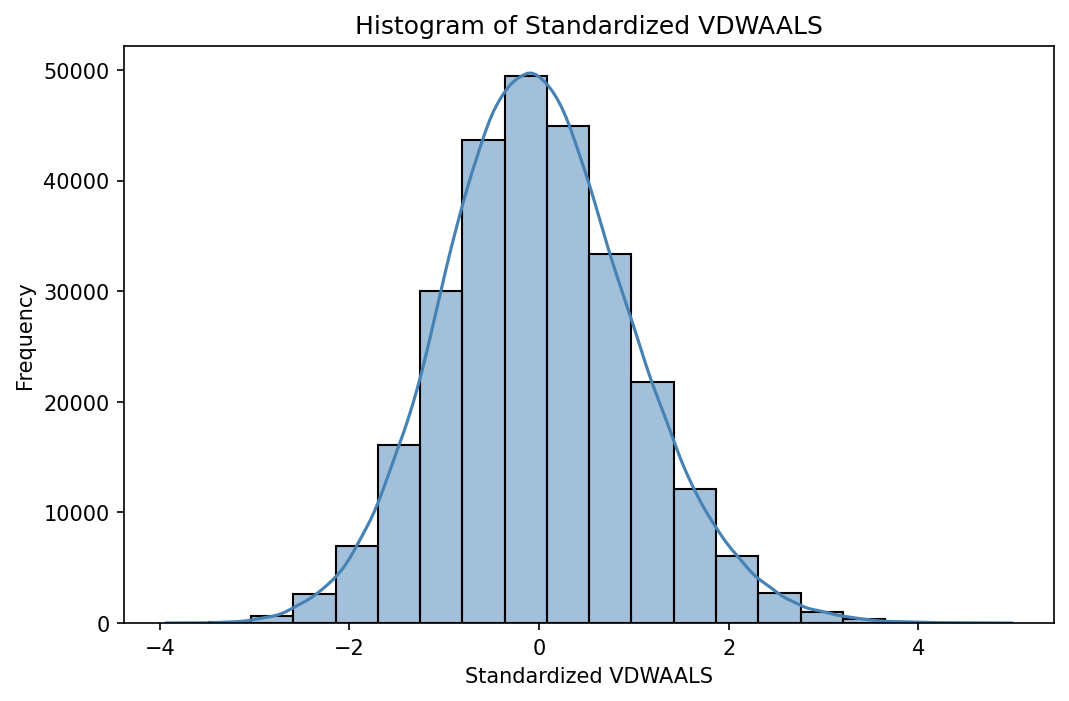

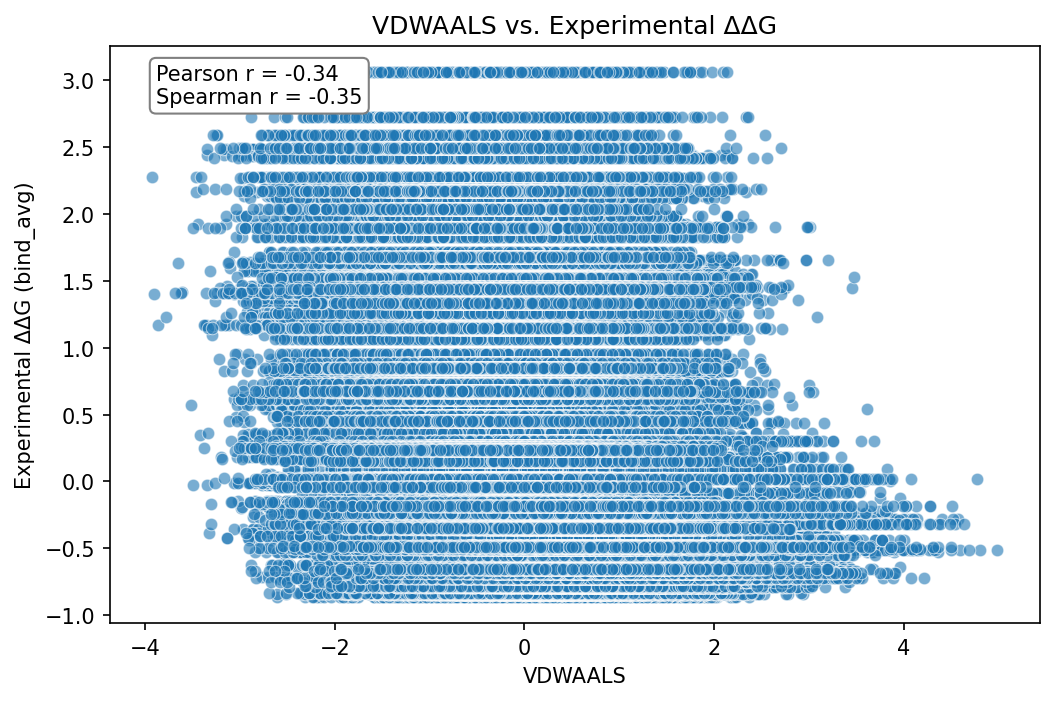

/var/folders/jg/f84gjnc17d51qj6zy5cb71lh0000gq/T/ipykernel_84199/670133172.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["binding_type"], y=df[std_col], palette="Set2")


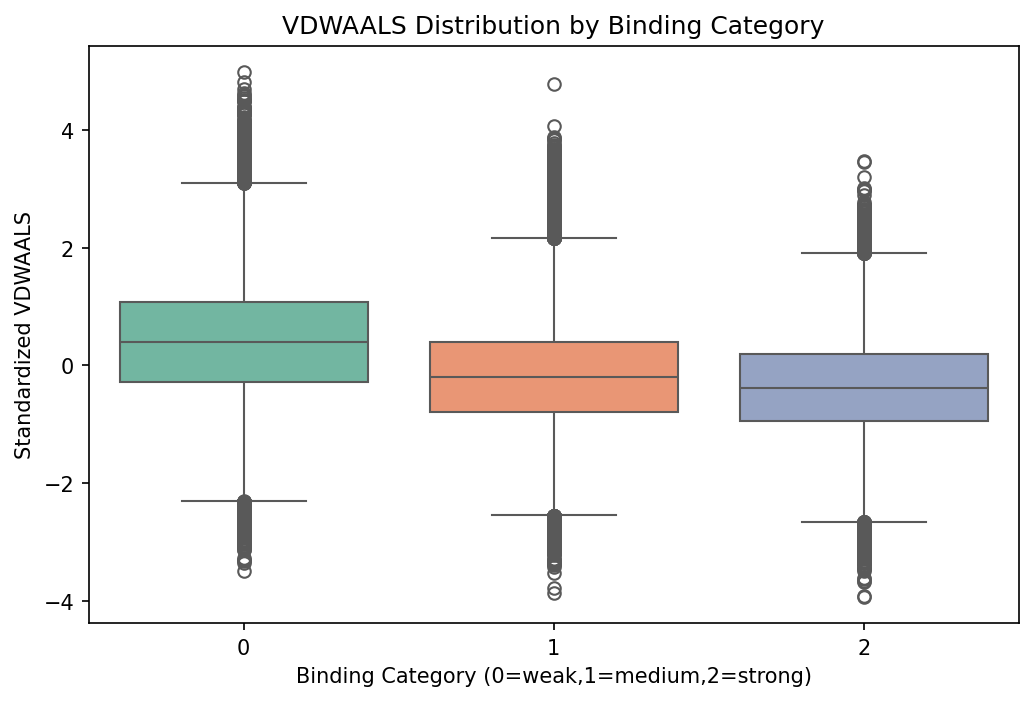

Term: VDWAALS
 • Avg. bootstrapped KW p-value: 1.736e-26
 • Full KW H-stat=30285.60, p-value=0.000e+00, η²=0.111
--------------------------------------------------


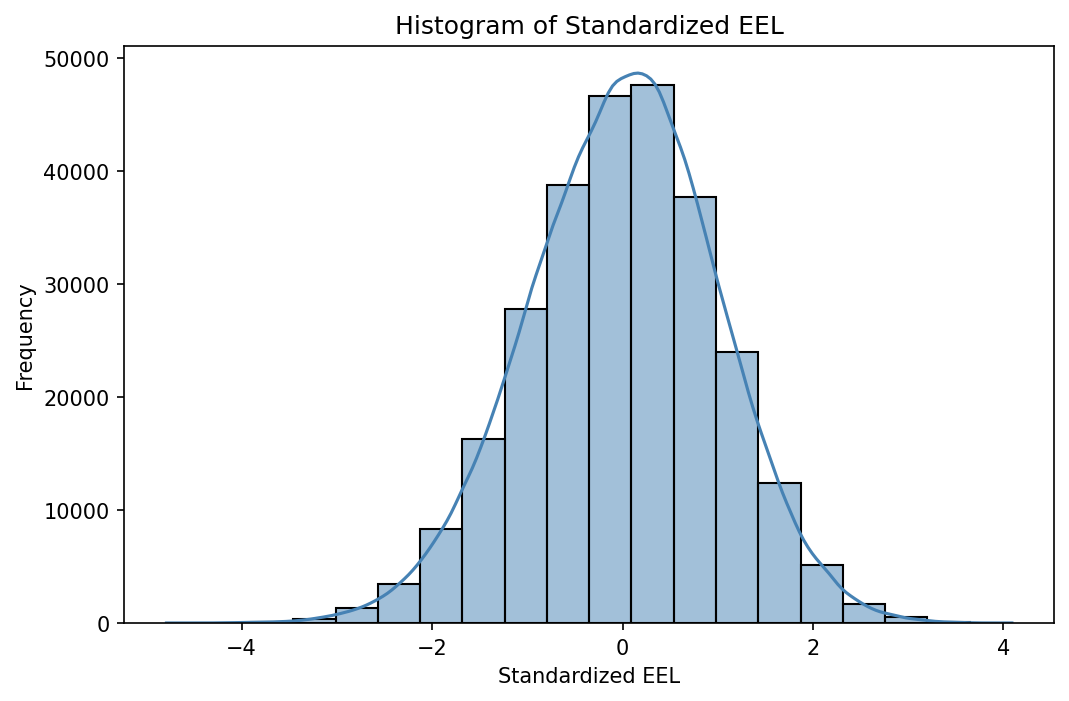

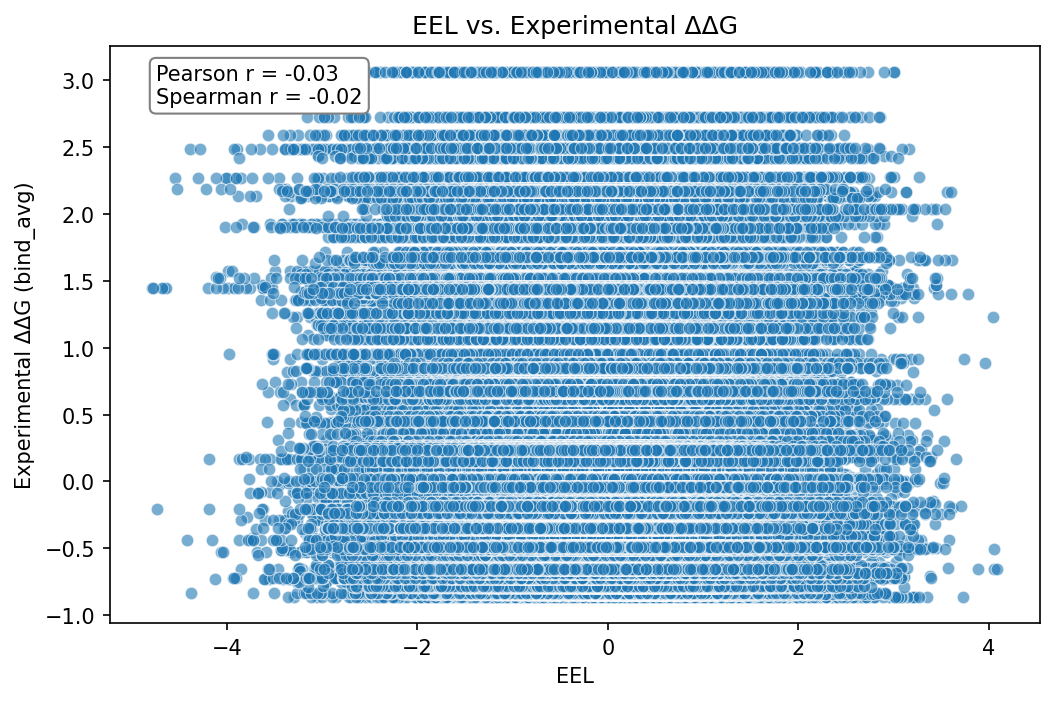

/var/folders/jg/f84gjnc17d51qj6zy5cb71lh0000gq/T/ipykernel_84199/670133172.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["binding_type"], y=df[std_col], palette="Set2")


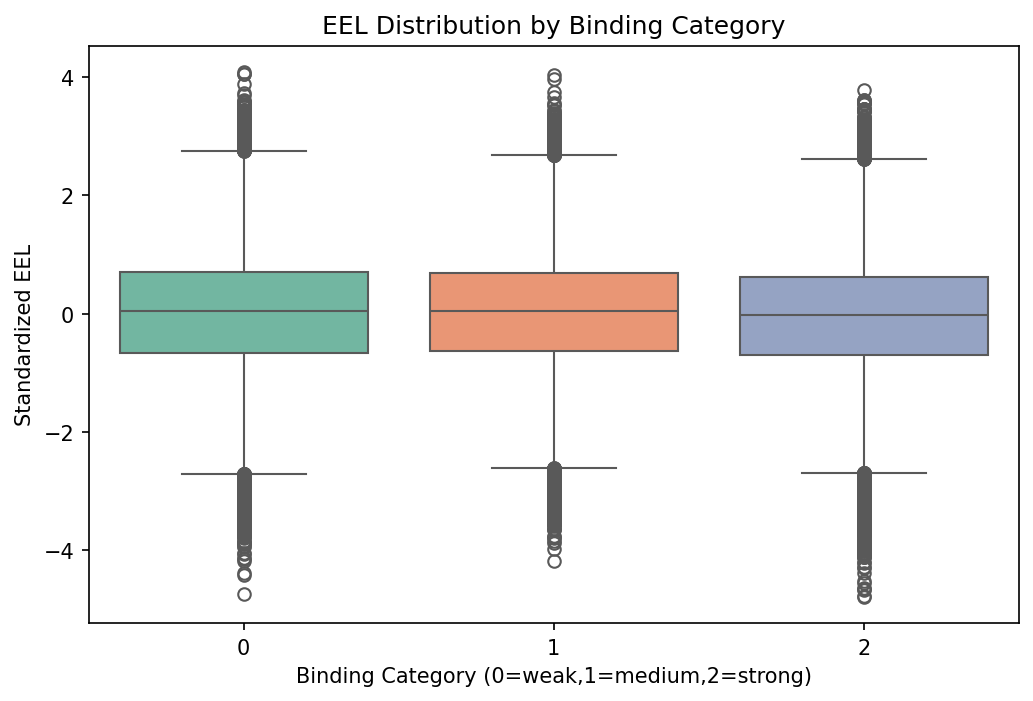

Term: EEL
 • Avg. bootstrapped KW p-value: 3.100e-01
 • Full KW H-stat=225.52, p-value=1.071e-49, η²=0.001
--------------------------------------------------


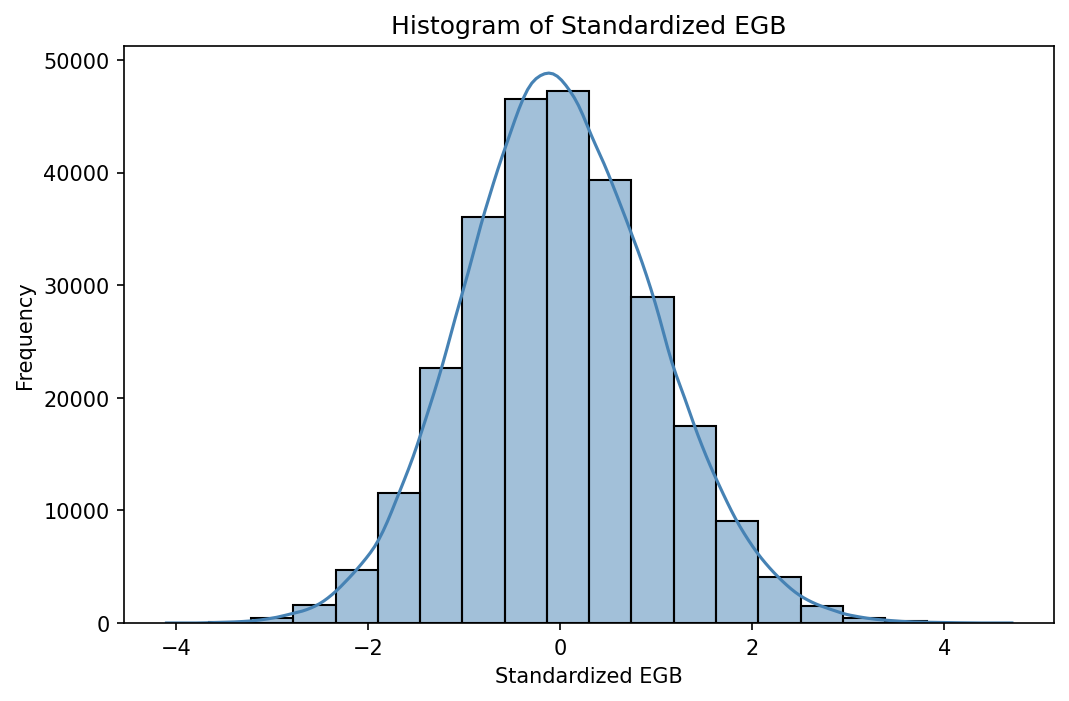

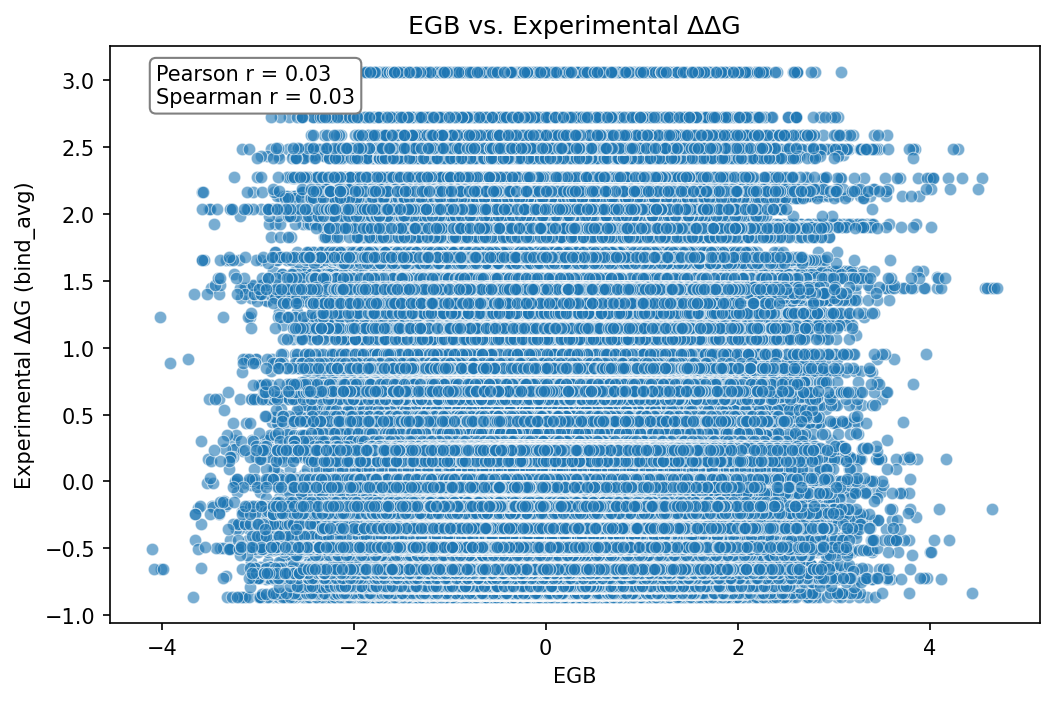

/var/folders/jg/f84gjnc17d51qj6zy5cb71lh0000gq/T/ipykernel_84199/670133172.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["binding_type"], y=df[std_col], palette="Set2")


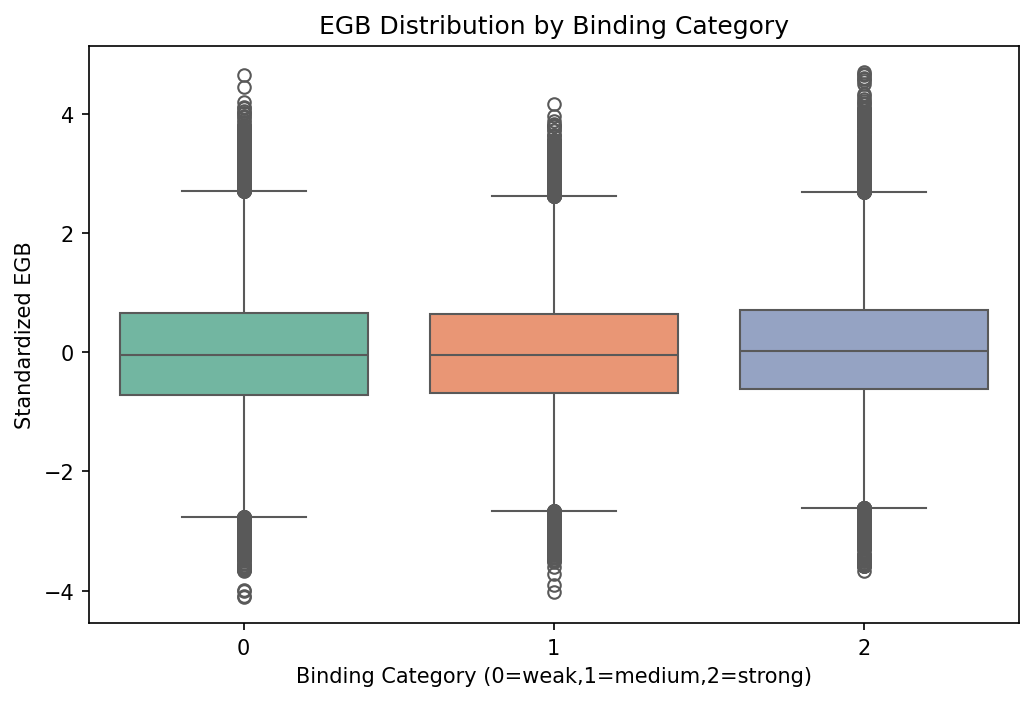

Term: EGB
 • Avg. bootstrapped KW p-value: 3.479e-01
 • Full KW H-stat=227.54, p-value=3.899e-50, η²=0.001
--------------------------------------------------


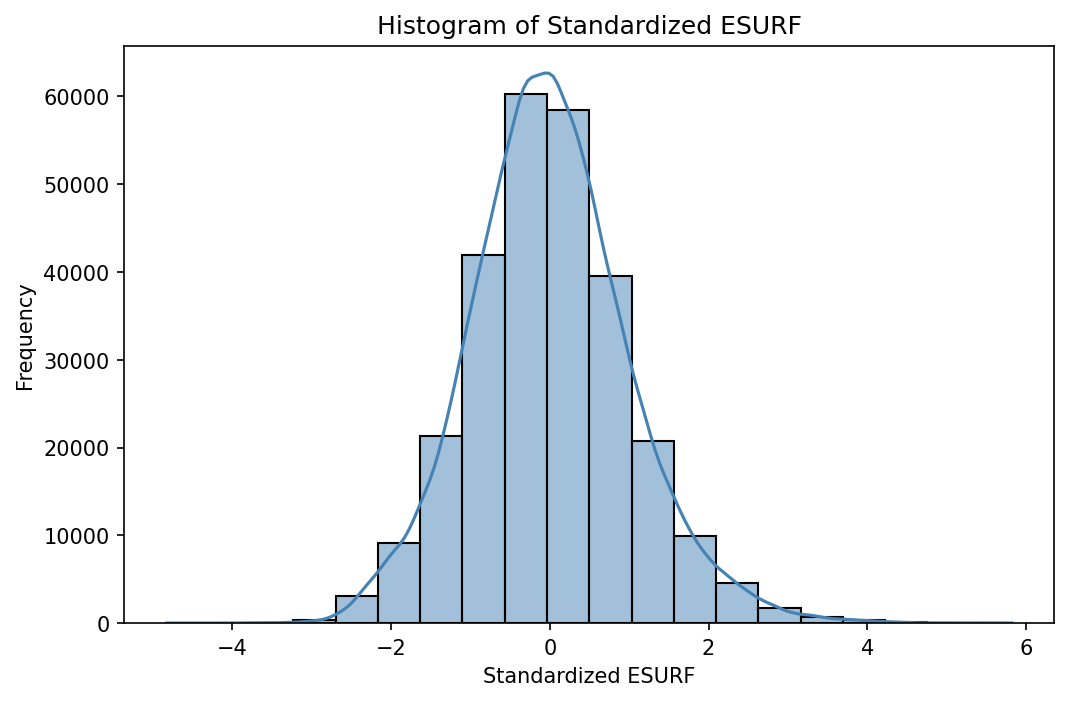

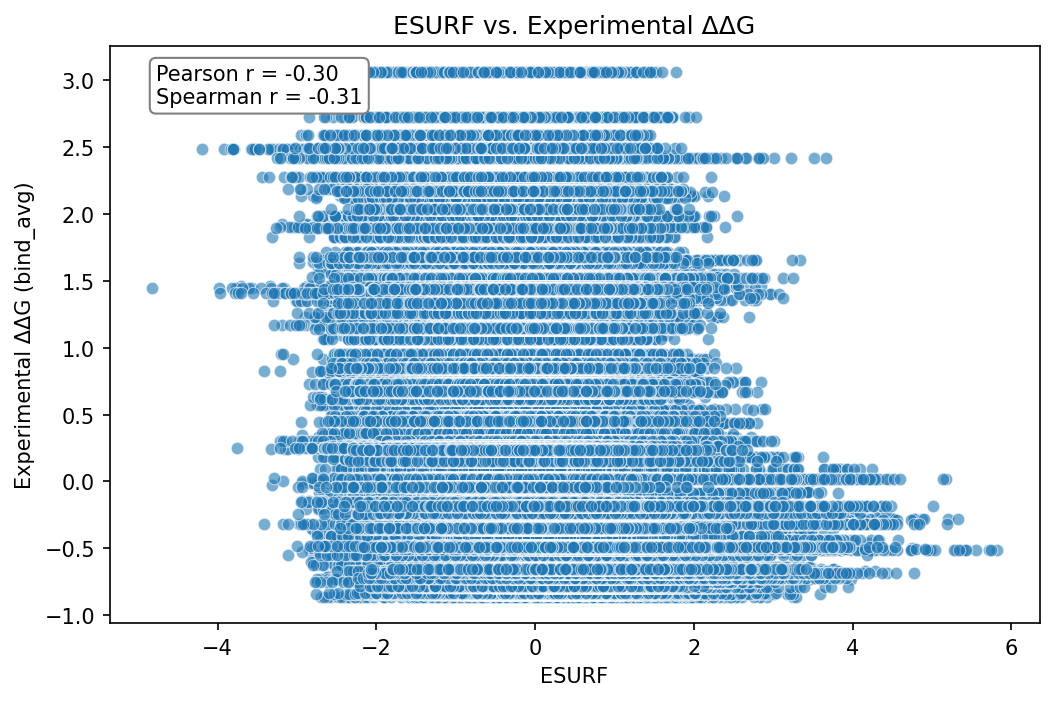

/var/folders/jg/f84gjnc17d51qj6zy5cb71lh0000gq/T/ipykernel_84199/670133172.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["binding_type"], y=df[std_col], palette="Set2")


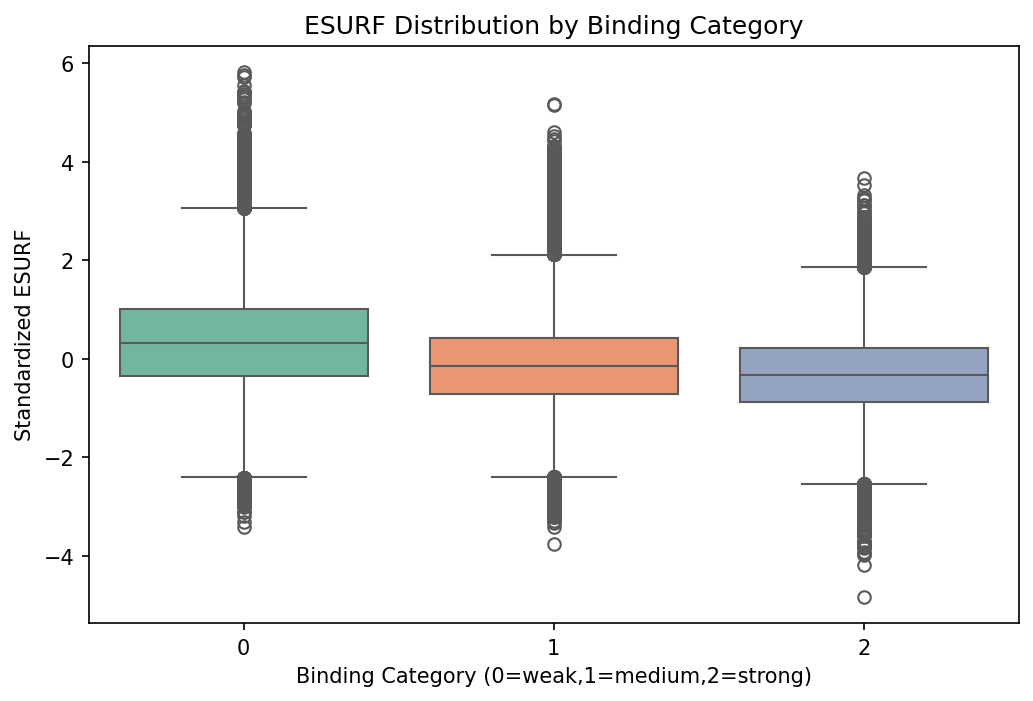

Term: ESURF
 • Avg. bootstrapped KW p-value: 1.674e-20
 • Full KW H-stat=22286.83, p-value=0.000e+00, η²=0.082
--------------------------------------------------


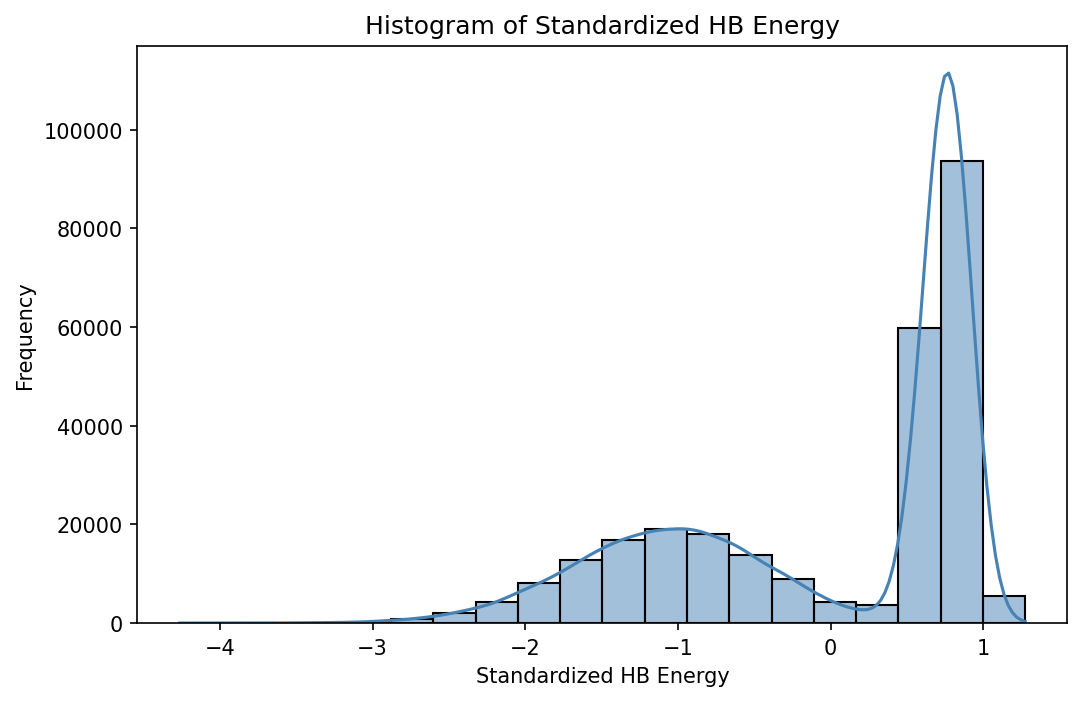

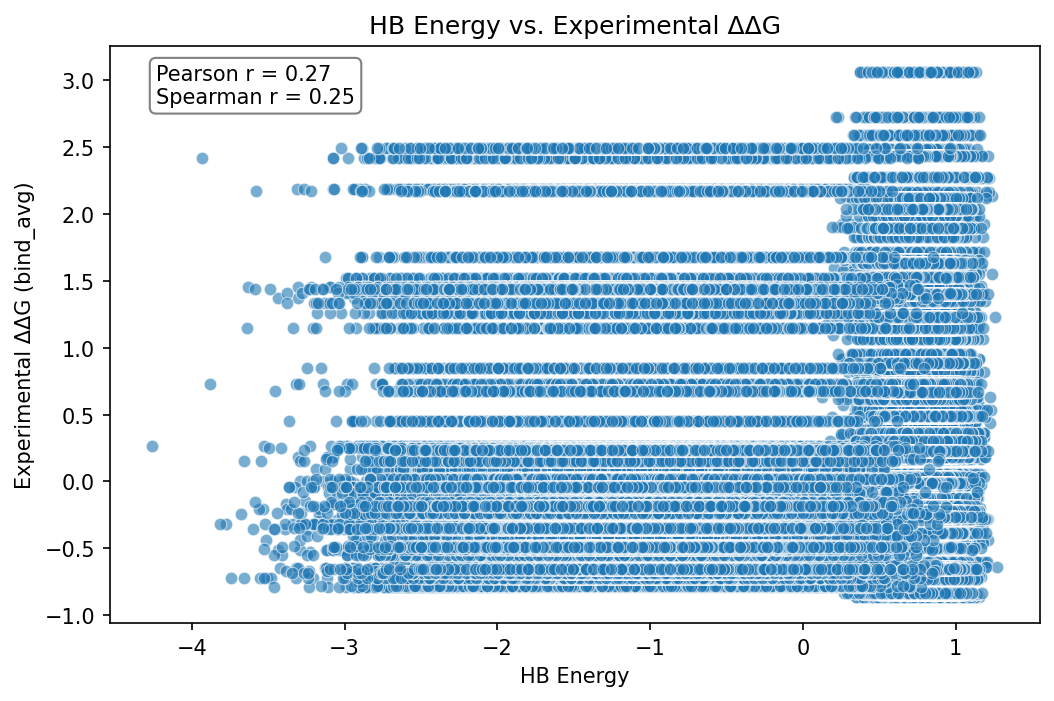

/var/folders/jg/f84gjnc17d51qj6zy5cb71lh0000gq/T/ipykernel_84199/670133172.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["binding_type"], y=df[std_col], palette="Set2")


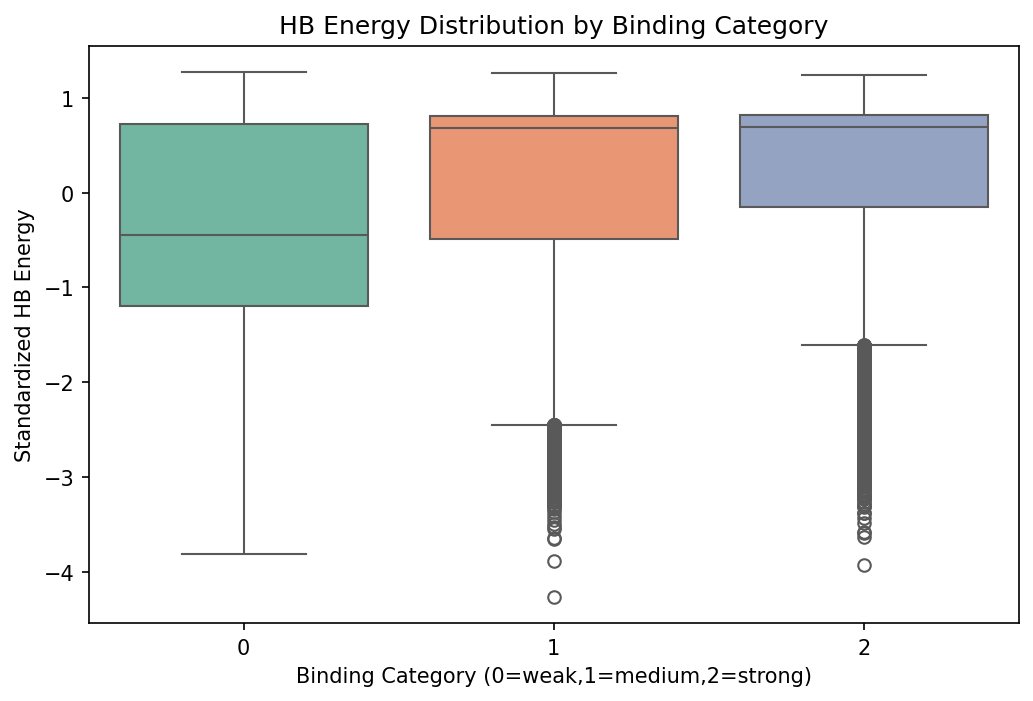

Term: HB Energy
 • Avg. bootstrapped KW p-value: 4.496e-15
 • Full KW H-stat=18633.09, p-value=0.000e+00, η²=0.068
--------------------------------------------------


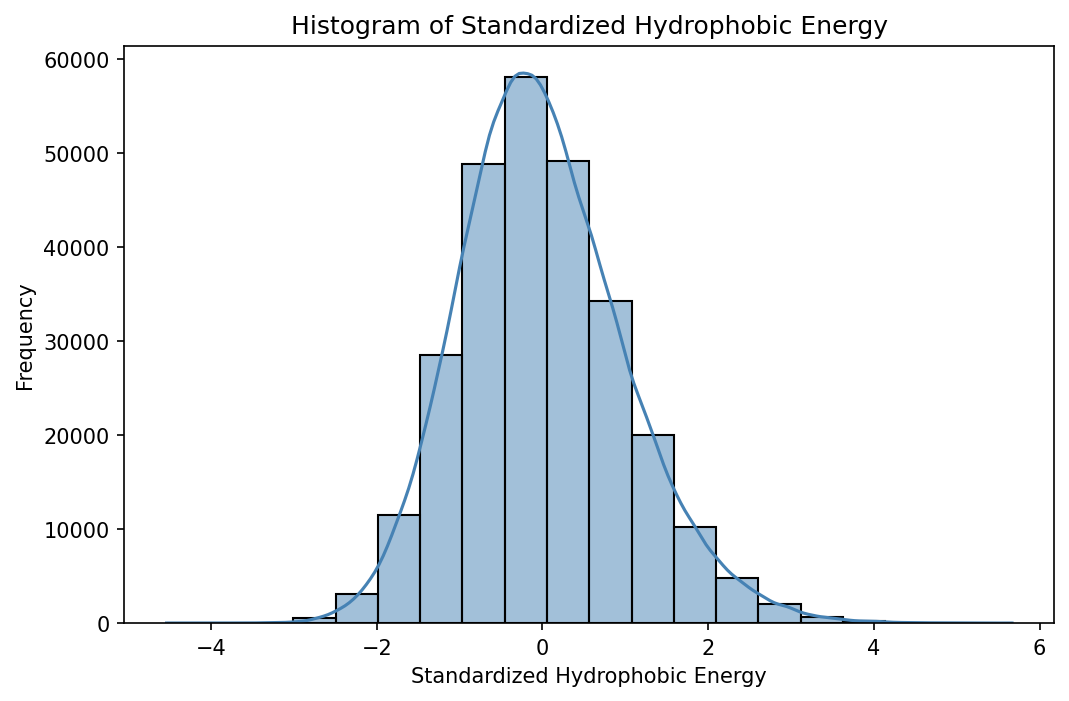

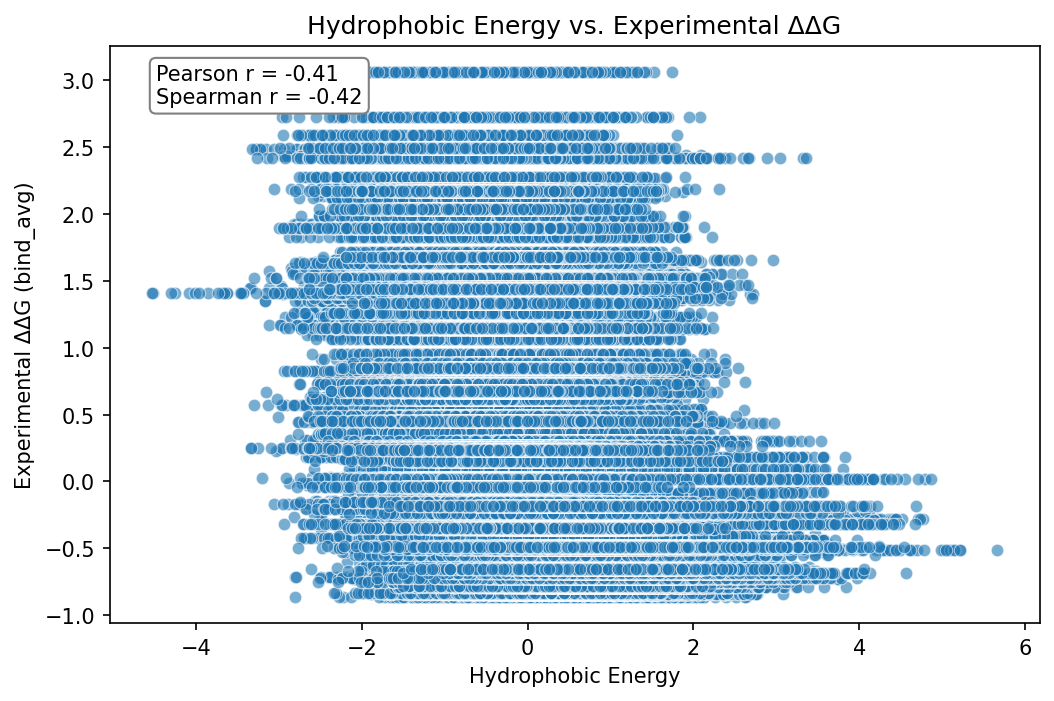

/var/folders/jg/f84gjnc17d51qj6zy5cb71lh0000gq/T/ipykernel_84199/670133172.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["binding_type"], y=df[std_col], palette="Set2")


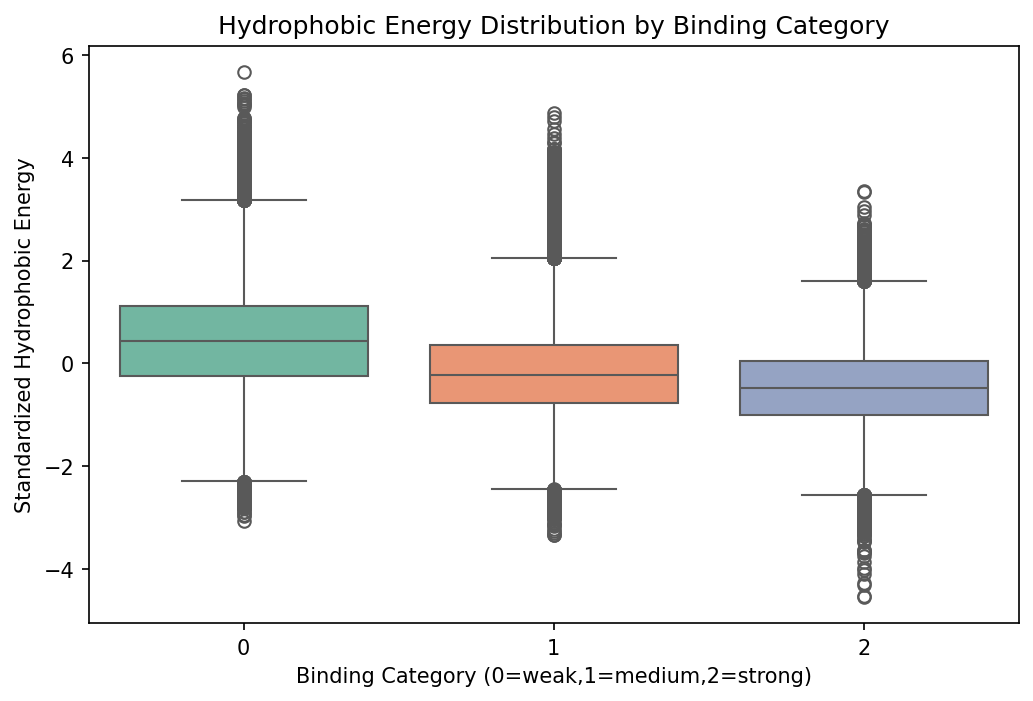

Term: Hydrophobic Energy
 • Avg. bootstrapped KW p-value: 3.122e-36
 • Full KW H-stat=41031.26, p-value=0.000e+00, η²=0.151
--------------------------------------------------


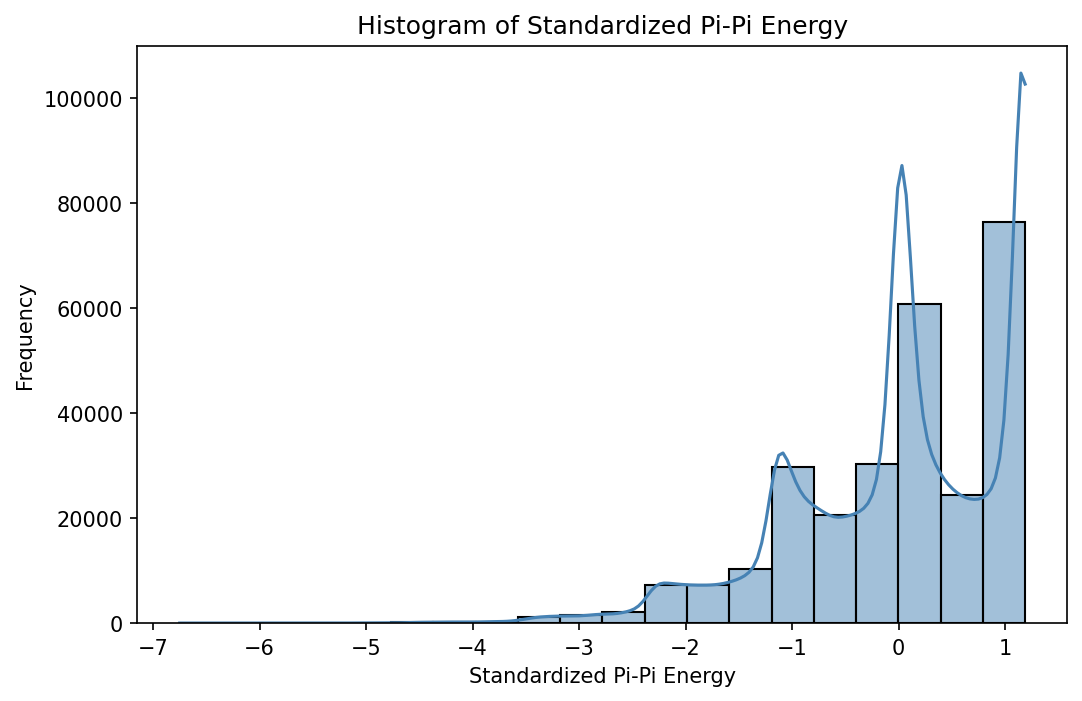

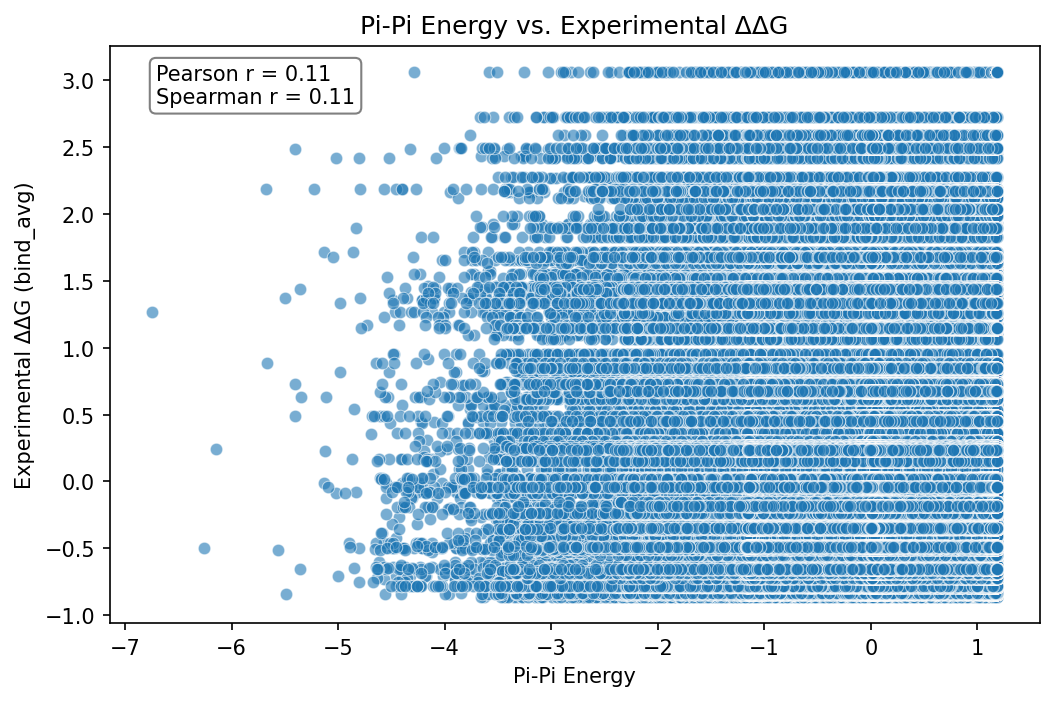

/var/folders/jg/f84gjnc17d51qj6zy5cb71lh0000gq/T/ipykernel_84199/670133172.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["binding_type"], y=df[std_col], palette="Set2")


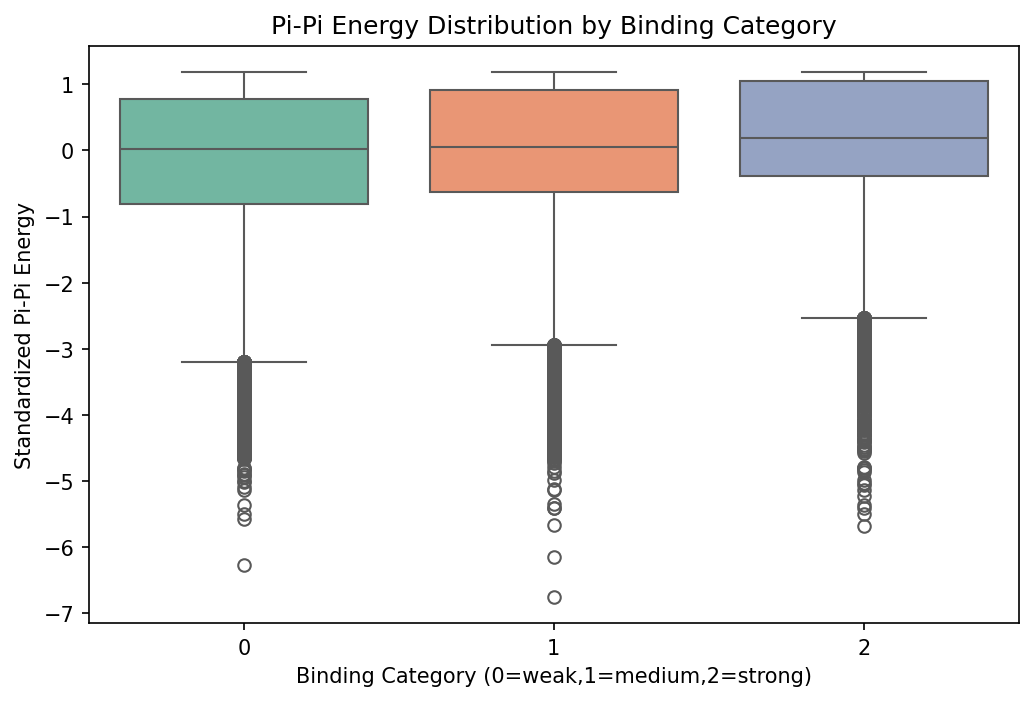

Term: Pi-Pi Energy
 • Avg. bootstrapped KW p-value: 1.872e-02
 • Full KW H-stat=2497.32, p-value=0.000e+00, η²=0.009
--------------------------------------------------


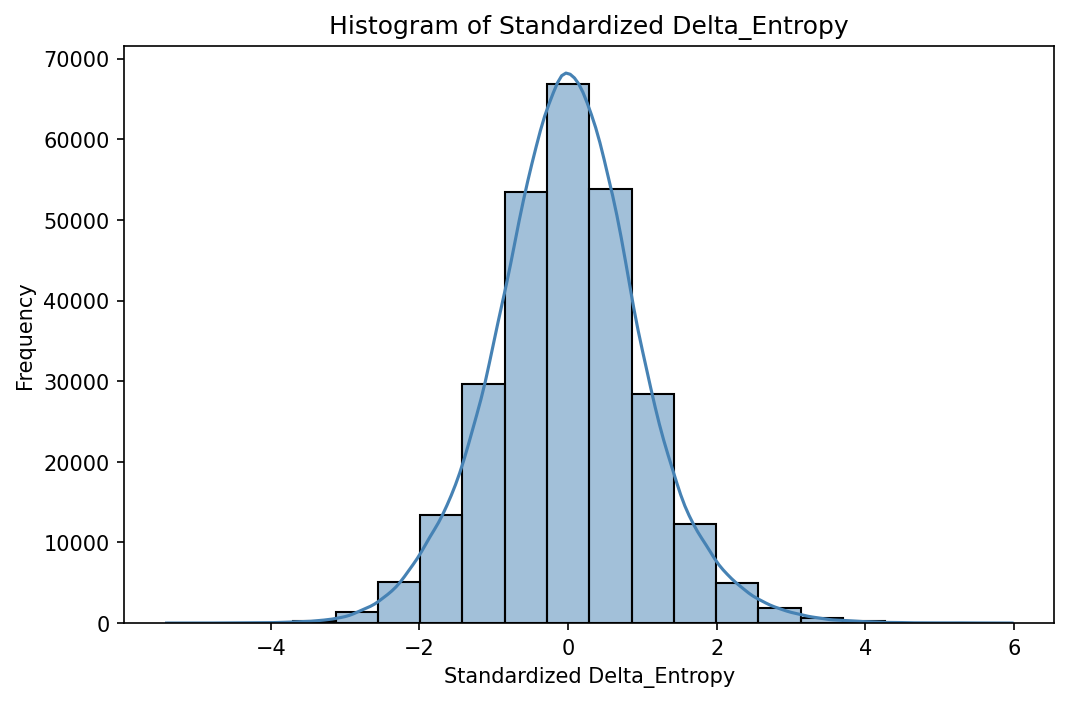

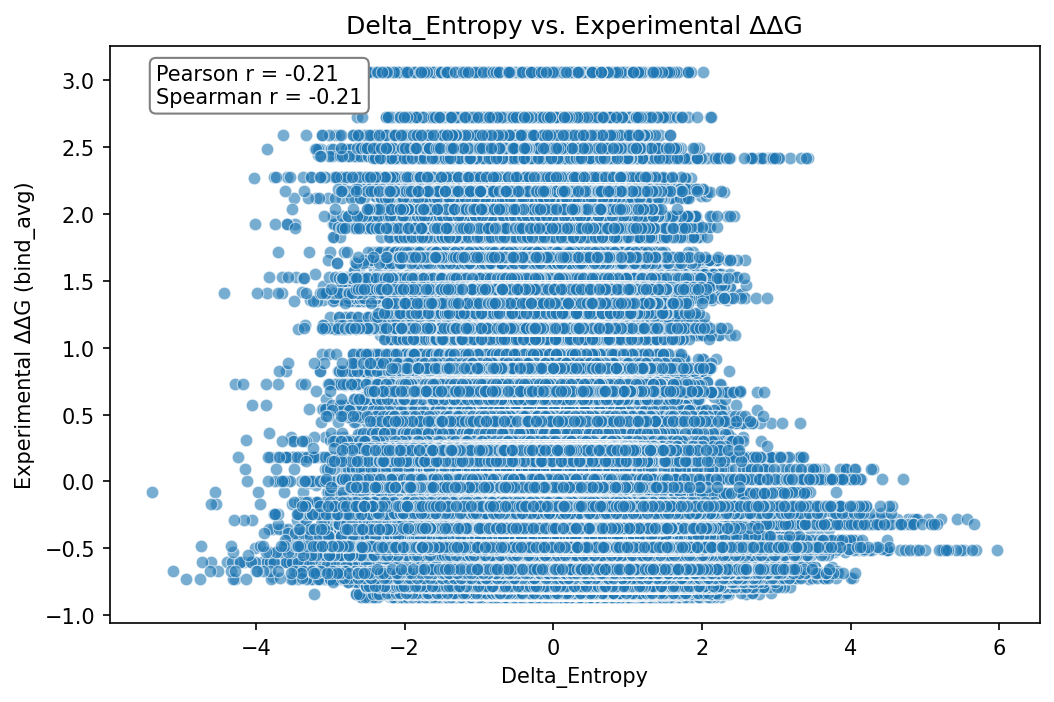

/var/folders/jg/f84gjnc17d51qj6zy5cb71lh0000gq/T/ipykernel_84199/670133172.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["binding_type"], y=df[std_col], palette="Set2")


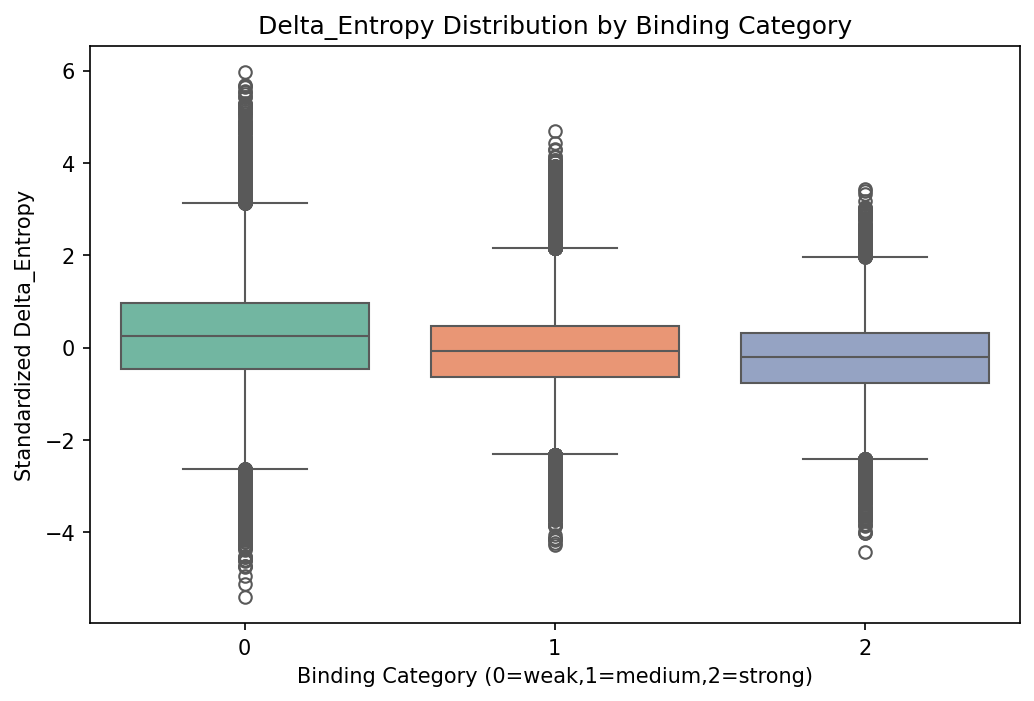

Term: Delta_Entropy
 • Avg. bootstrapped KW p-value: 3.057e-09
 • Full KW H-stat=11327.36, p-value=0.000e+00, η²=0.042
--------------------------------------------------


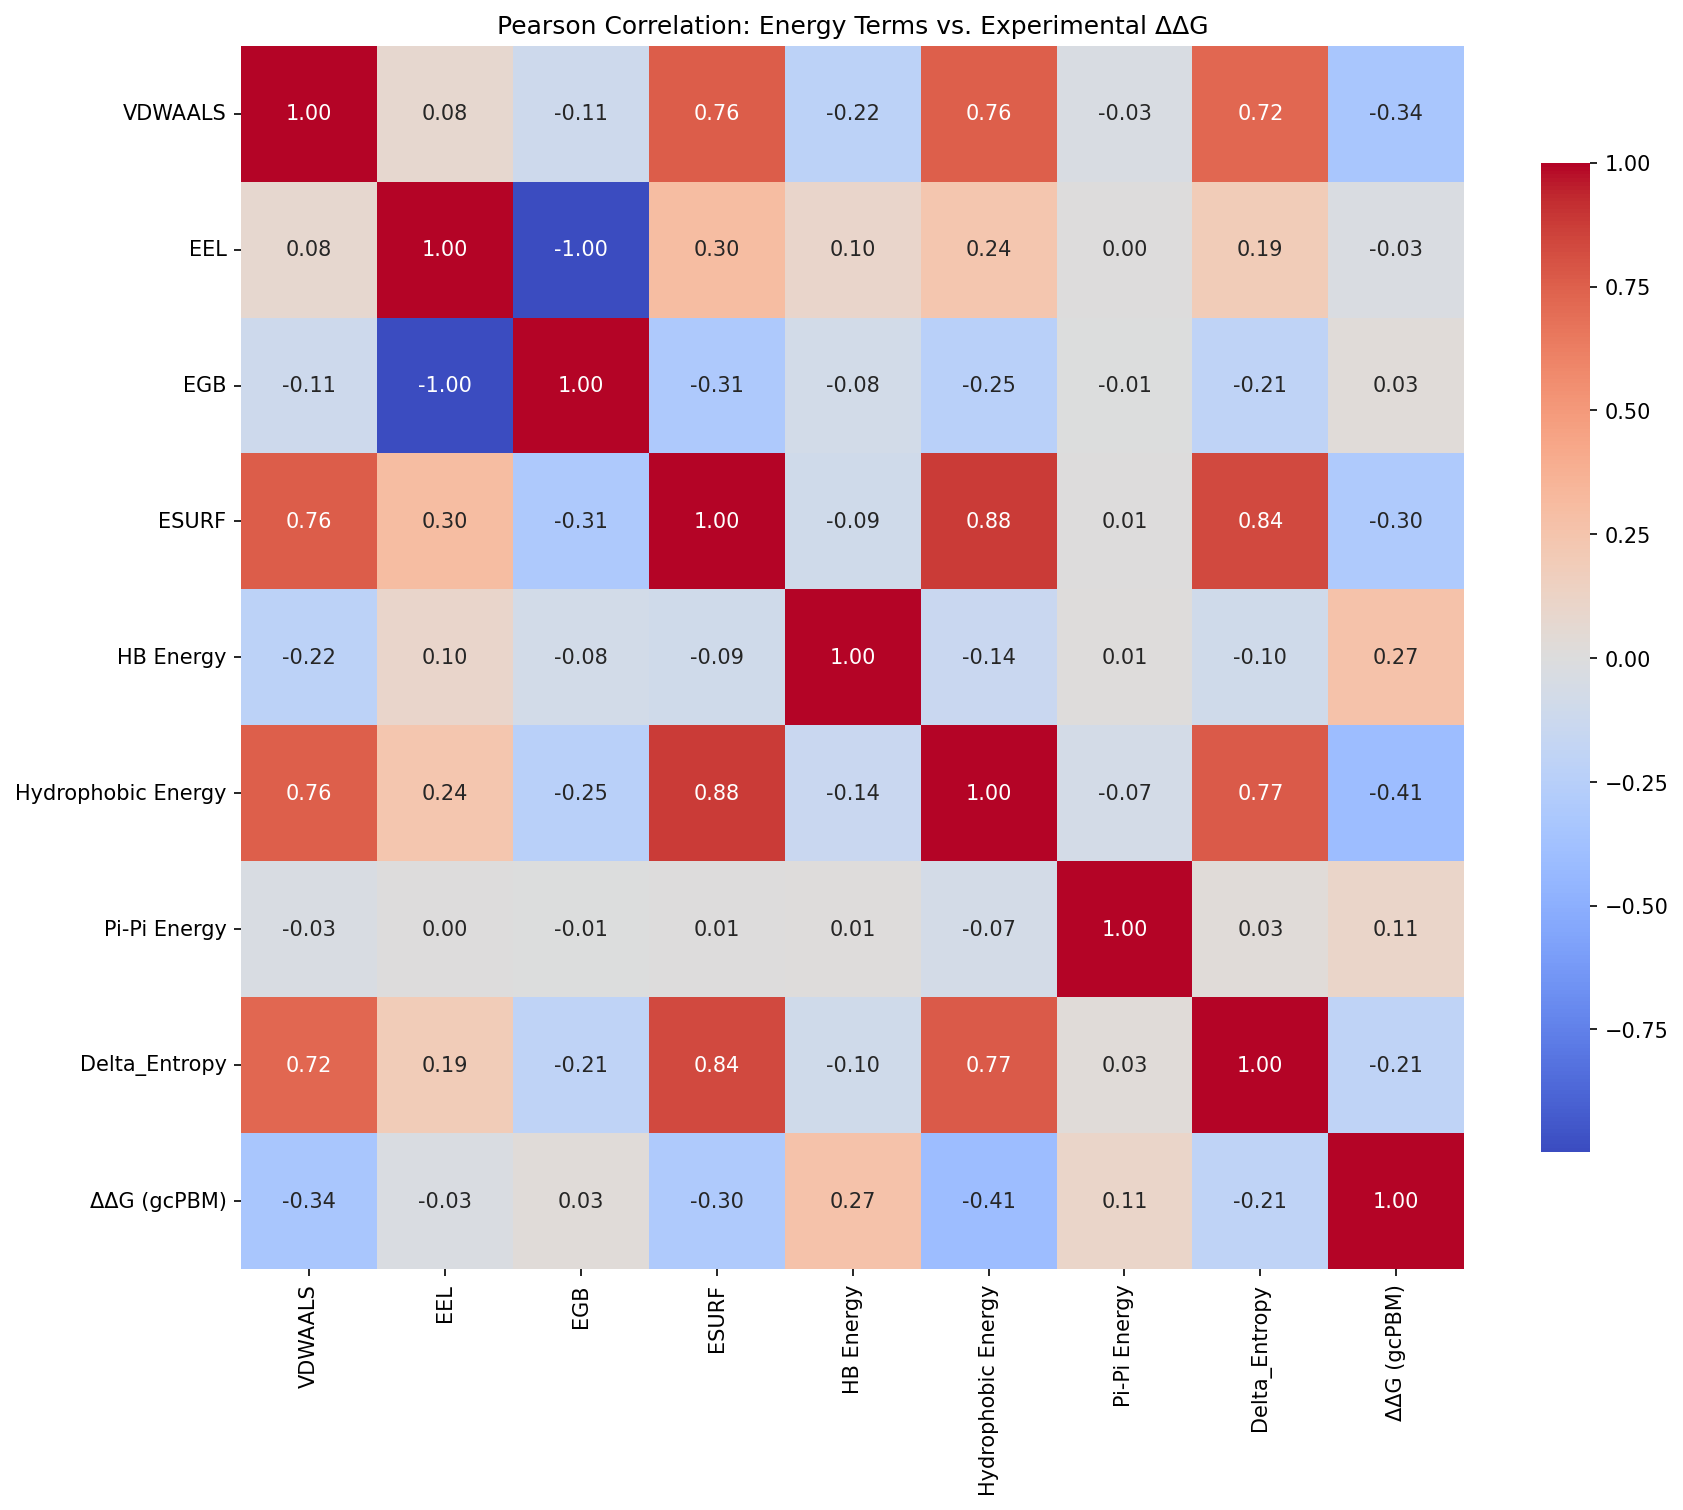

In [18]:
# 1) Load and merge computed vs. experimental data
# ------------------------------------------------
test1 = pd.read_csv("rawdat.csv")  
# Strip off any prefix in the sequence column
test1["sequence"] = test1["sequence"].str.replace("MycMax_", "", regex=False)

test2 = pd.read_csv("exp_data_all.csv")  
# Merge on the 'sequence' key, bringing in bind_avg, binding_type, etc.
df = pd.merge(test1, test2, on="sequence", how="left")

# Drop any sequences without experimental data
df = df.dropna()

# 2) Function to compute η² effect size from Kruskal–Wallis H
# -------------------------------------------------------------
def eta_squared(kruskal_stat, num_groups, total_size):
    """
    Eta-squared estimate of effect size from a KW H-statistic.
      η² = (H - k + 1) / (N - k)
    where k = number of groups, N = total sample size.
    """
    return (kruskal_stat - num_groups + 1) / (total_size - num_groups)

# 3) Loop over each energy term in the computed data
# ---------------------------------------------------
energy_terms = test1.drop(columns=['sequence','run']).columns

for term in energy_terms:
    # a) Standardize this term (zero mean, unit variance)
    std_col = f"{term} (std)"
    df[std_col] = (df[term] - df[term].mean()) / df[term].std()

    # --- 3.1) Histogram of standardized values
    plt.figure(figsize=(8, 5), dpi=150)
    sns.histplot(df[std_col], bins=20, kde=True, color="steelblue")
    plt.xlabel(f"Standardized {term}")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Standardized {term}")
    plt.show()

    # --- 3.2) Scatter vs. bind_avg (with correlation coefficients)
    plt.figure(figsize=(8, 5), dpi=150)
    sns.scatterplot(x=df[std_col], y=df["bind_avg"], alpha=0.6)
    plt.xlabel(term)
    plt.ylabel("Experimental ΔΔG (bind_avg)")
    plt.title(f"{term} vs. Experimental ΔΔG")

    r_pearson, _ = pearsonr(df[std_col], df["bind_avg"])
    r_spearman, _ = spearmanr(df[std_col], df["bind_avg"])
    plt.text(
        0.05, 0.90,
        f"Pearson r = {r_pearson:.2f}\nSpearman r = {r_spearman:.2f}",
        transform=plt.gca().transAxes,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray")
    )
    plt.show()

    # --- 3.3) Boxplot distribution by binding_type (0/1/2 categories)
    plt.figure(figsize=(8, 5), dpi=150)
    sns.boxplot(x=df["binding_type"], y=df[std_col], palette="Set2")
    plt.xlabel("Binding Category (0=weak,1=medium,2=strong)")
    plt.ylabel(f"Standardized {term}")
    plt.title(f"{term} Distribution by Binding Category")
    plt.show()

    # --- 3.4) Bootstrapped Kruskal–Wallis tests
    p_vals = []
    for _ in range(100):
        # sample up to 500 per class to balance
        sampled = df.groupby("binding_type").sample(
            n=min(500, len(df)), 
            random_state=np.random.randint(0,1e6)
        )
        groups = [
            sampled[sampled["binding_type"]==bt][term]
            for bt in sampled["binding_type"].unique()
        ]
        h_stat, p_val = kruskal(*groups)
        p_vals.append(p_val)
    avg_p = np.mean(p_vals)

    # full-dataset Kruskal–Wallis
    full_groups = [
        df[df["binding_type"]==bt][term]
        for bt in df["binding_type"].unique()
    ]
    h_full, p_full = kruskal(*full_groups)
    η2 = eta_squared(h_full, len(full_groups), len(df))

    print(f"Term: {term}")
    print(f" • Avg. bootstrapped KW p-value: {avg_p:.3e}")
    print(f" • Full KW H-stat={h_full:.2f}, p-value={p_full:.3e}, η²={η2:.3f}")
    print("-"*50)

# 4) Correlation Heatmap of all standardized energy terms vs. experimental ΔΔG
# -----------------------------------------------------------------------------
# Build list of standardized columns that exist in df
std_cols = [f"{t} (std)" for t in energy_terms]
cols_for_corr = [c for c in std_cols + ["bind_avg"] if c in df.columns]

# Compute Pearson correlation matrix
corr = df[cols_for_corr].corr(method="pearson")

# Relabel for display
label_map = {c: ("ΔΔG (gcPBM)" if c=="bind_avg" else c.replace(" (std)","")) for c in corr.columns}
corr = corr.rename(columns=label_map, index=label_map)

plt.figure(figsize=(12,10), dpi=150)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Pearson Correlation: Energy Terms vs. Experimental ΔΔG")
plt.tight_layout()
plt.show()